This notebook tests the iMaster algorithm presented in section 4 of the paper, especially the results in fig. 4.

In [1]:
from imaster_paper_args import *

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid12236/


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8811 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32979 instead
  warnings.warn(


In [2]:
nside=512
window_lmax=nside
use_window=False

do_pseudo_cl=False
do_xi=True

bin_cl=True
bin_xi=True

use_binned_l=False
use_binned_theta=False

do_cov=False

In [3]:
#setup tomographic bins
shear_zbins=lsst_source_tomo_bins(nbins=1,use_window=use_window,nside=nside,f_sky=f_sky,zp=np.array([z0_shear]),ns0=ns0_shear)
galaxy_zbins=lsst_source_tomo_bins(nbins=1,use_window=use_window,nside=nside,f_sky=f_sky,zp=np.array([z0_galaxy]),ns0=ns0_galaxy)

ns0:  30.0
[1] 100 5
source_tomo_bins, zmax 5.0 1 0.3
Tracer utils has no tracers
ns0:  10.0
[0.5] 100 5
source_tomo_bins, zmax 5.0 0.5 0.22499999999999998
Tracer utils has no tracers


In [4]:
corrs=[corr_gg]#corr_ll,corr_gg,corr_ggl]
corr=corrs[0]
s=s1_s2s[corr]
if corr==corr_ll:
    s=(2,2)

In [5]:
#setup parameters
lmax_cl=3000 #2000
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+1
lmax_cl_Bins=lmax_cl-1
Nl_bins=50
# l_bins=get_l_bins(l_min=lmin_cl_Bins,l_max=lmax_cl_Bins,N_bins=Nl_bins,binning_scheme='log',min_modes=50)#,binning_mode='decreasing')
l_bins=np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins+1)))
lb=.5*(l_bins[1:]+l_bins[:-1])
l_bins_center=lb*1
Nl_bins=len(lb)

# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
l=l0

In [6]:
theta_min=0.01/60
# theta_min=hp.nside2resol(512, arcmin = True)/60 #100/nside #1./60
theta_max=1200./60
n_theta_bins=151
# theta_bins,th=get_theta_bins(theta_min=theta_min,theta_max=theta_max,N_bins=n_theta_bins,binning_scheme='log',n_theta_samples=40)#,max_modes=1)
theta_bins=np.logspace(np.log10(theta_min),np.log10(theta_max),n_theta_bins+1)
th=np.logspace(np.log10(theta_min),np.log10(theta_max),n_theta_bins*40)
theta_bins_center=0.5*(theta_bins[1:]+theta_bins[:-1])
thb=theta_bins_center*1
n_theta_bins=len(thb)

In [7]:
#Hankel Transform setup
WT_kwargs={'l':l0,'l_cut_weights':None,'theta':th*d2r,'s1_s2':[(0,0),s],
           'wig_d_taper_order_low':None,'wig_d_taper_order_high':None} 
# if globals().get('WT') is None:
WT=wigner_transform(**WT_kwargs )
# WT_b=wigner_transform(**WT_kwargs)
WT_b=WT
WT.gather_data()

Scattering WT data 1


In [8]:
Skylens_kwargs=parse_dict(locals())
Skylens_kwargs_ub=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs_ub['bin_xi']=False
Skylens_kwargs_ub['bin_cl']=False
Skylens_kwargs_ub['theta_bins']=th

In [9]:
SL_xi0_ub=Skylens(**Skylens_kwargs_ub)
SL_xi0=Skylens(**Skylens_kwargs)


Tracer utils has tracers:  ['shear', 'galaxy']


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:92: RuntimeWarning: invalid value encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide


pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 100 3000 513.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 100 3000 513.0 2
Window done. Size: 0.0


In [10]:
cl_bu=client.gather(SL_xi0.cl_bin_utils)
xi_bu=client.gather(SL_xi0.xi_bin_utils)

In [11]:
%time xiHG_ub=SL_xi0_ub.xi_tomo()
# %time xiH_ub=xiHG_ub['stack'].compute() #FIXME: bug in unbinned stacking
%time xi0ub=client.compute(xiHG_ub['xi']).result()
%time clG_ub=SL_xi0_ub.cl_tomo()
# %time xiH_ub=xiHG_ub['stack'].compute() #FIXME: bug in unbinned stacking
%time cl0ub=client.compute(clG_ub['cl']).result()

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:115: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
Done xi graph 0.000847 145.379
CPU times: user 12.9 s, sys: 601 ms, total: 13.5 s
Wall time: 15.7 s
CPU times: user 35.7 ms, sys: 111 ms, total: 147 ms
Wall time: 635 ms
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 28.9 ms, sys: 123 ms, total: 152 ms
Wall time: 516 ms
CPU times: user 7.25 ms, sys: 74 µs, total: 7.32 ms
Wall time: 22.6 ms


In [12]:
l_bins_center=SL_xi0.binning.bin_1d(xi=cl0ub[corr][bi]*SL_xi0_ub.l,bin_utils=cl_bu)
l_bins_center/=SL_xi0.binning.bin_1d(xi=cl0ub[corr][bi],bin_utils=cl_bu)

theta_bins_center=SL_xi0.binning.bin_1d(xi=xi0ub[corr][s][bi]*WT.theta_deg[s],bin_utils=xi_bu[s])
theta_bins_center/=SL_xi0.binning.bin_1d(xi=xi0ub[corr][s][bi],bin_utils=xi_bu[s])

In [13]:
Skylens_kwargs=parse_dict(locals())
Skylens_kwargs_b=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs_b['use_binned_l']=True
Skylens_kwargs_b['use_binned_theta']=True
Skylens_kwargs_b['WT']=WT_b

In [14]:
SL_xi0=Skylens(**Skylens_kwargs)
SL_xi0b=Skylens(**Skylens_kwargs_b)

Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 100 3000 513.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 100 3000 513.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 100 43 513.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology inte

In [15]:
cl_bu=client.gather(SL_xi0.cl_bin_utils)
xi_bu=client.gather(SL_xi0.xi_bin_utils)

In [16]:
%time xiHG0=SL_xi0.xi_tomo()
%time xiH0=xiHG0['stack'].compute()
%time xi0=client.compute(xiHG0['xi']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
Done xi graph 0.000847 145.381
CPU times: user 12.8 s, sys: 610 ms, total: 13.4 s
Wall time: 5.53 s
CPU times: user 58.2 ms, sys: 233 ms, total: 291 ms
Wall time: 956 ms
CPU times: user 29.4 ms, sys: 112 ms, total: 141 ms
Wall time: 564 ms


In [17]:
%time xiHG_b=SL_xi0b.xi_tomo()
%time xiH_b=xiHG_b['stack'].compute()
%time xi0b=client.compute(xiHG_b['xi']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
Done xi graph 0.000847 145.31
CPU times: user 12.8 s, sys: 603 ms, total: 13.4 s
Wall time: 5.68 s
CPU times: user 111 ms, sys: 458 ms, total: 569 ms
Wall time: 1.38 s
CPU times: user 8.59 ms, sys: 4.17 ms, total: 12.8 ms
Wall time: 32.7 ms


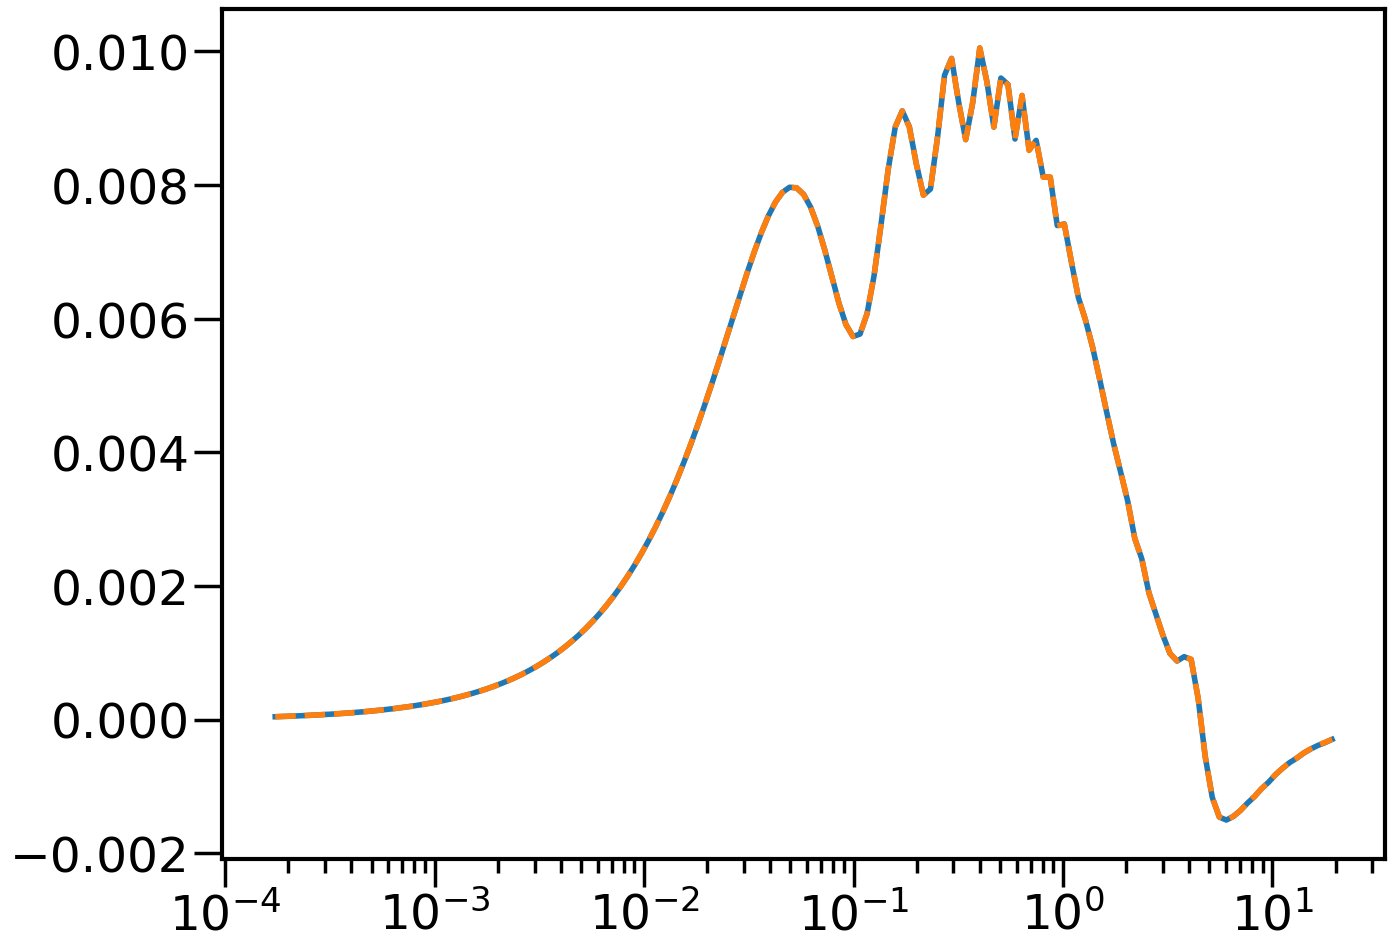

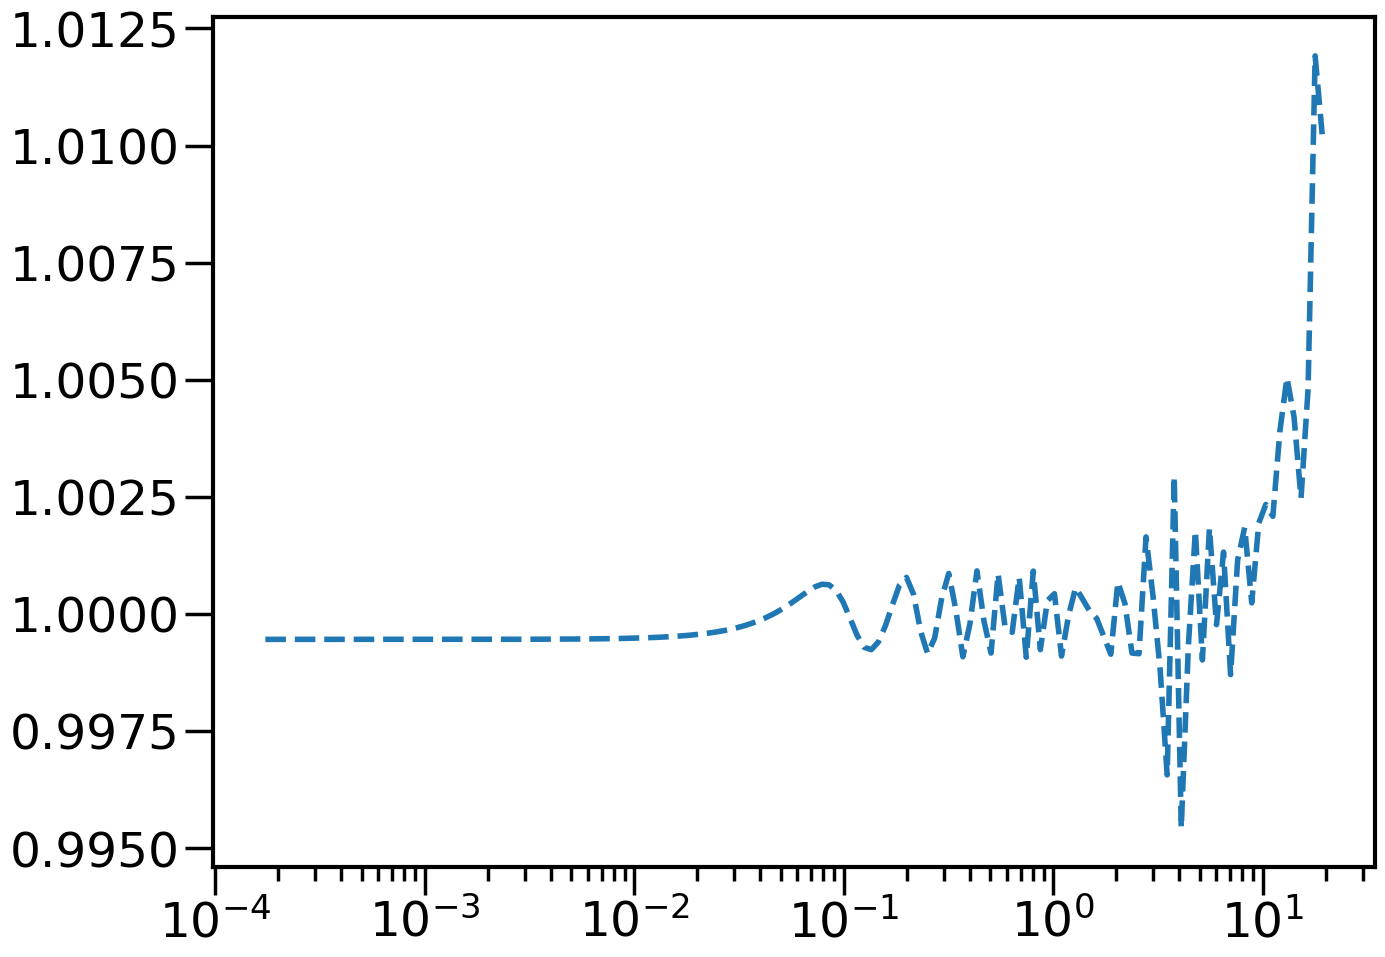

In [18]:
#compare full binned calculation with the `binned' iMaster
plot(thb,thb*xi0b[corr][s][bi])
plot(thb,thb*xi0[corr][s][bi],'--')
xscale('log')
show()
plot(thb,xi0b[corr][s][bi]/xi0[corr][s][bi],'--')
xscale('log')

In [19]:
def bin_2d_WT_inv(wig_mat=[],wig_norm=None,bin_utils_xi=None,bin_utils_cl=None,
                wt_b=None,wt0=None,use_binned_l=False,win_xi=None):

        wig_mat=wig_mat*wig_norm
#         wig_mat=wig_mat.T
        if bin_utils_xi is not None:
            binning_mat_xi=bin_utils_xi['binning_mat']
            if wt_b is None:
                wt_b=bin_utils_xi['wt_b']
            if wt0 is None:
                wt0=bin_utils_xi['wt0']
            if len(wt0.shape)==1:
                binning_mat_xi2=wt0[:,None]*binning_mat_xi*wt_b
            else:
                binning_mat_xi2=wt0@binning_mat_xi@wt_b #FIXME: Test this.
            print(wig_mat.shape,binning_mat_xi2.shape)
            wm=wig_mat@binning_mat_xi2
            
        else:
            wm=wig_mat
        
        wig_mat_b=wm
        if bin_utils_cl is not None and use_binned_l:
            bin_mat_cl=bin_utils_cl['binning_mat']
            
            rdr=bin_utils_cl['r_dr']
            bin_mat_cl=bin_mat_cl*rdr[:,None]/bin_utils_cl['norm'][None,:]
            
            wig_mat_b=bin_mat_cl.T@wm
        return wig_mat_b

In [20]:
%time clG0b=SL_xi0b.cl_tomo()
%time cl0b=client.compute(clG0b['cl_b']).result()

%time clG0=SL_xi0.cl_tomo()
%time cl0=client.compute(clG0['cl_b']).result()

%time cl0_0=client.compute(clG0['cl']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 36.7 ms, sys: 120 ms, total: 156 ms
Wall time: 601 ms
CPU times: user 9.57 ms, sys: 203 µs, total: 9.77 ms
Wall time: 34.1 ms
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 47 ms, sys: 111 ms, total: 158 ms
Wall time: 605 ms
CPU times: user 8.66 ms, sys: 280 µs, total: 8.94 ms
Wall time: 29.3 ms
CPU times: user 8.86 ms, sys: 151 µs, total: 9.01 ms
Wall time: 30 ms


In [21]:
wd_b=SL_xi0b.WT_binned[corr][s][bi].result()
wd_bi=numpy.linalg.pinv(wd_b)

In [22]:
wd_bi2=SL_xi0b.inv_WT_binned[corr][s][bi].result()

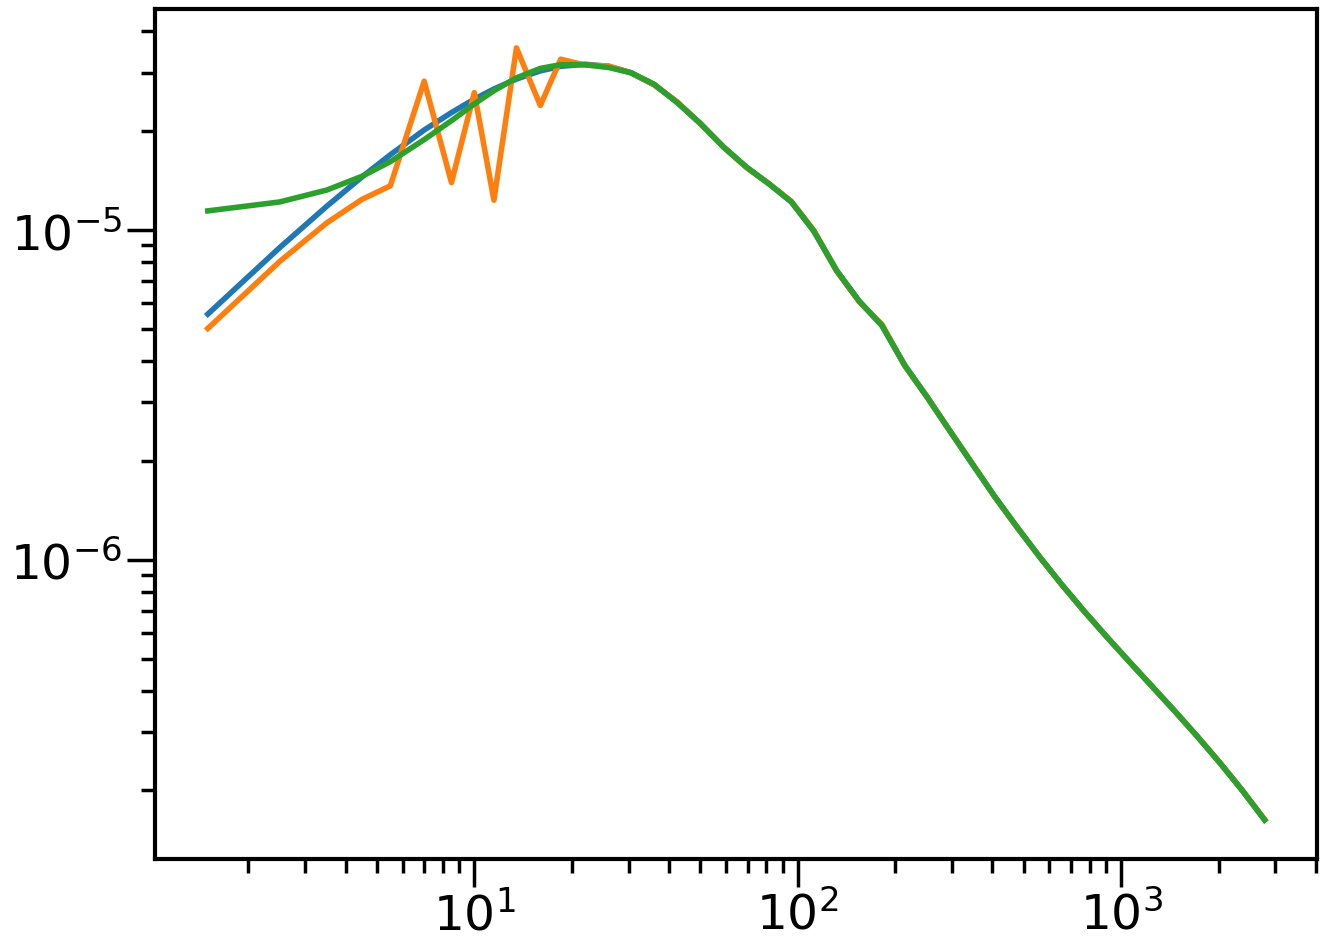

(0.9, 1.21)

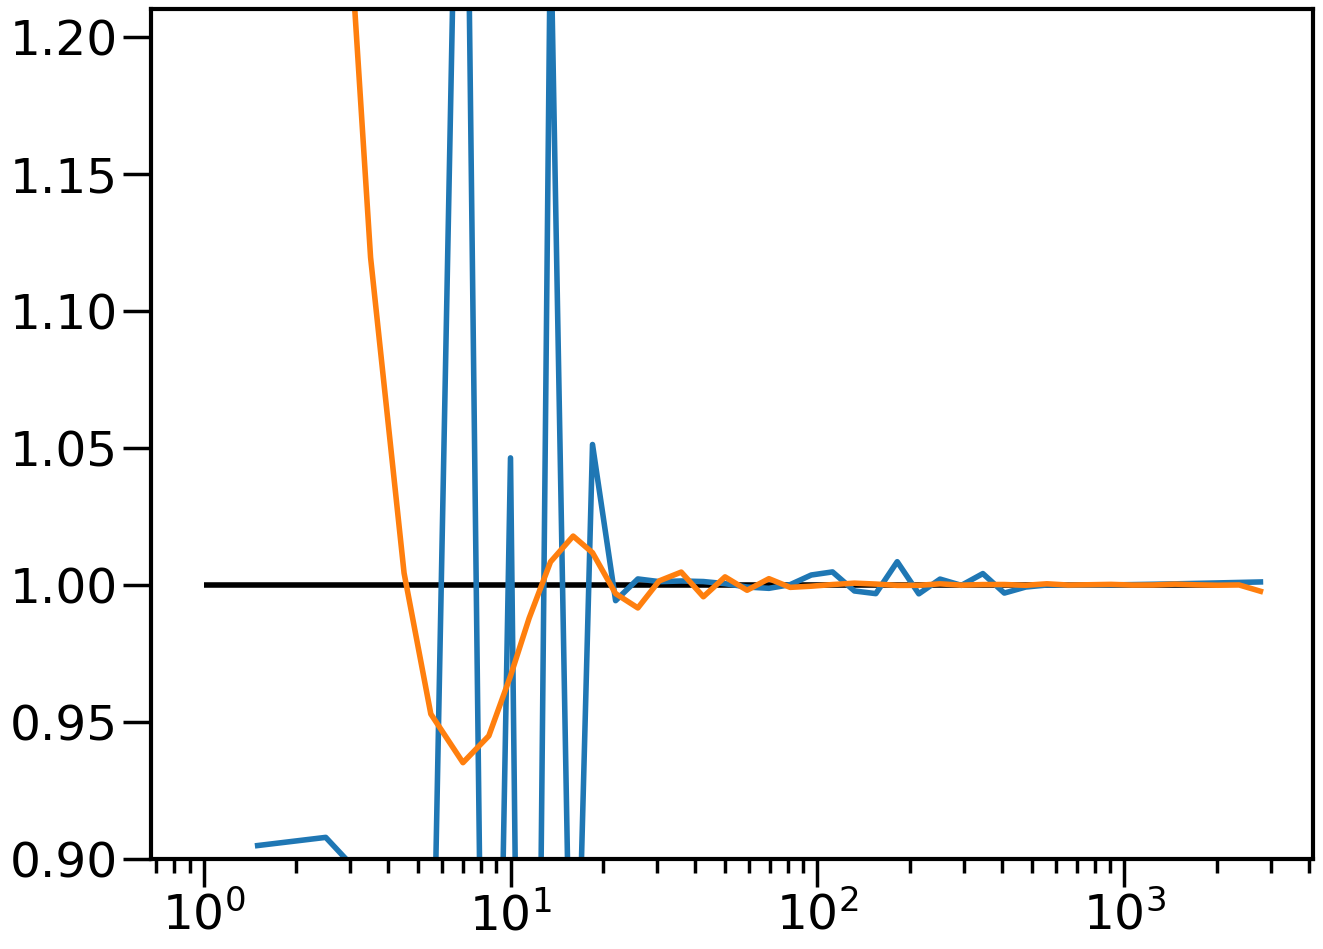

In [23]:
#reconstructing pseudo-power spectra. Large scales are biased wrt C_ell due to missing large theta values.
plot(lb,cl0[corr][(0,0)])
plot(lb,wd_bi@xi0b[corr][s][bi])
plot(lb,(wd_bi2@xi0b[corr][s][bi]))
loglog()
show()
plot(lb,wd_bi@xi0b[corr][s][bi]/cl0[corr][bi])
plot(lb,wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi])
hlines(1,1,2000,color='k')
xscale('log')
ylim(0.9,1.21)

(10, 2000)

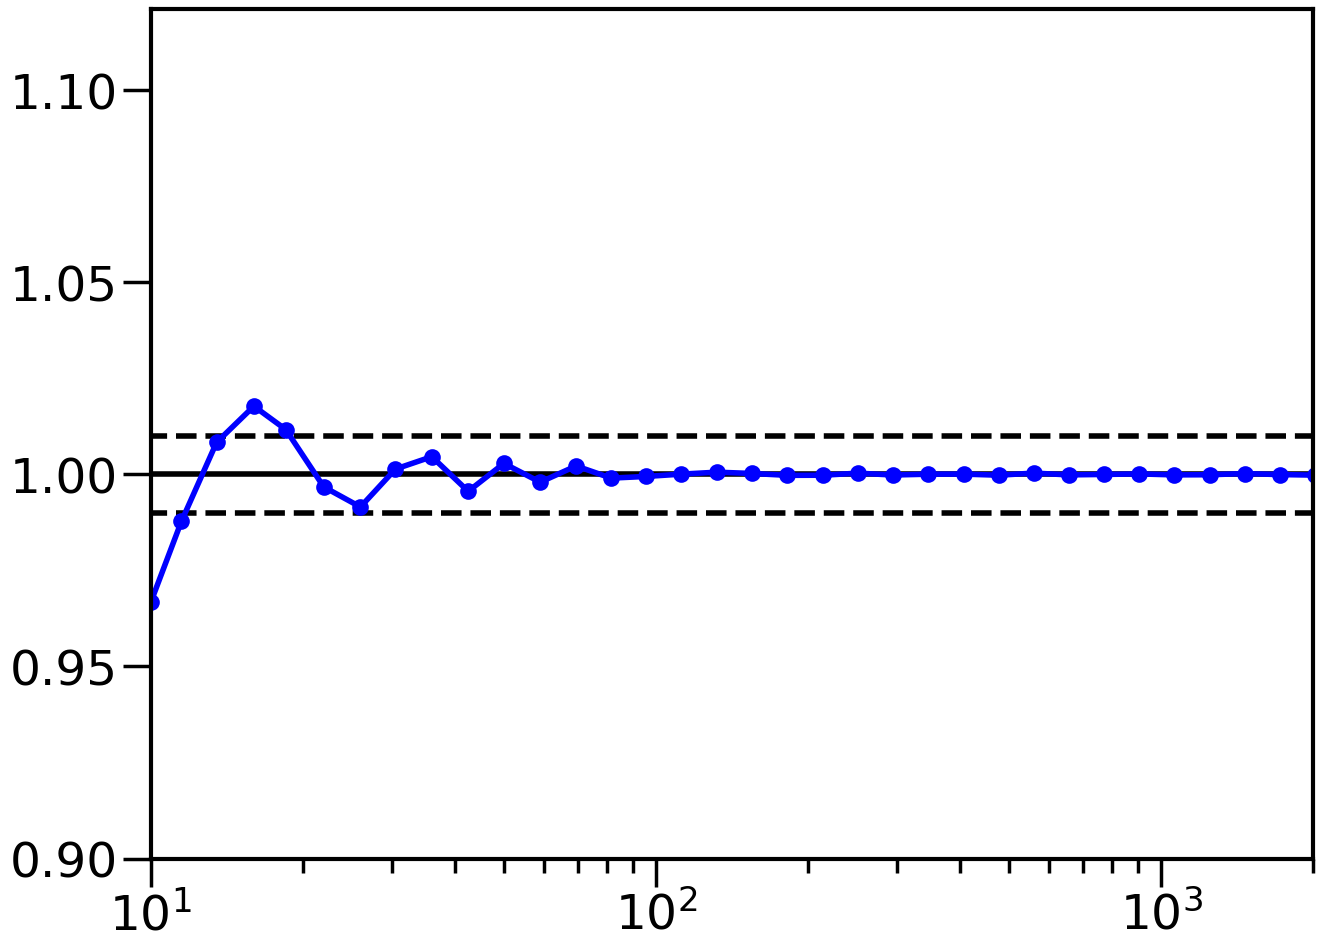

In [24]:
plot(lb,wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],'bo-')
hlines(1,1,2000,color='k')
hlines(1.01,1,2000,color='k',ls='--')
hlines(.99,1,2000,color='k',ls='--')
xscale('log')
ylim(0.9,1.121)
xlim(10,2000)

<ipython-input-34-b2bb2ea054fe>:33: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  pR.set_yscale('symlog',linthreshy=0.01)


saved to  ./figures/WT_inv_th_min_comp_gg.pdf


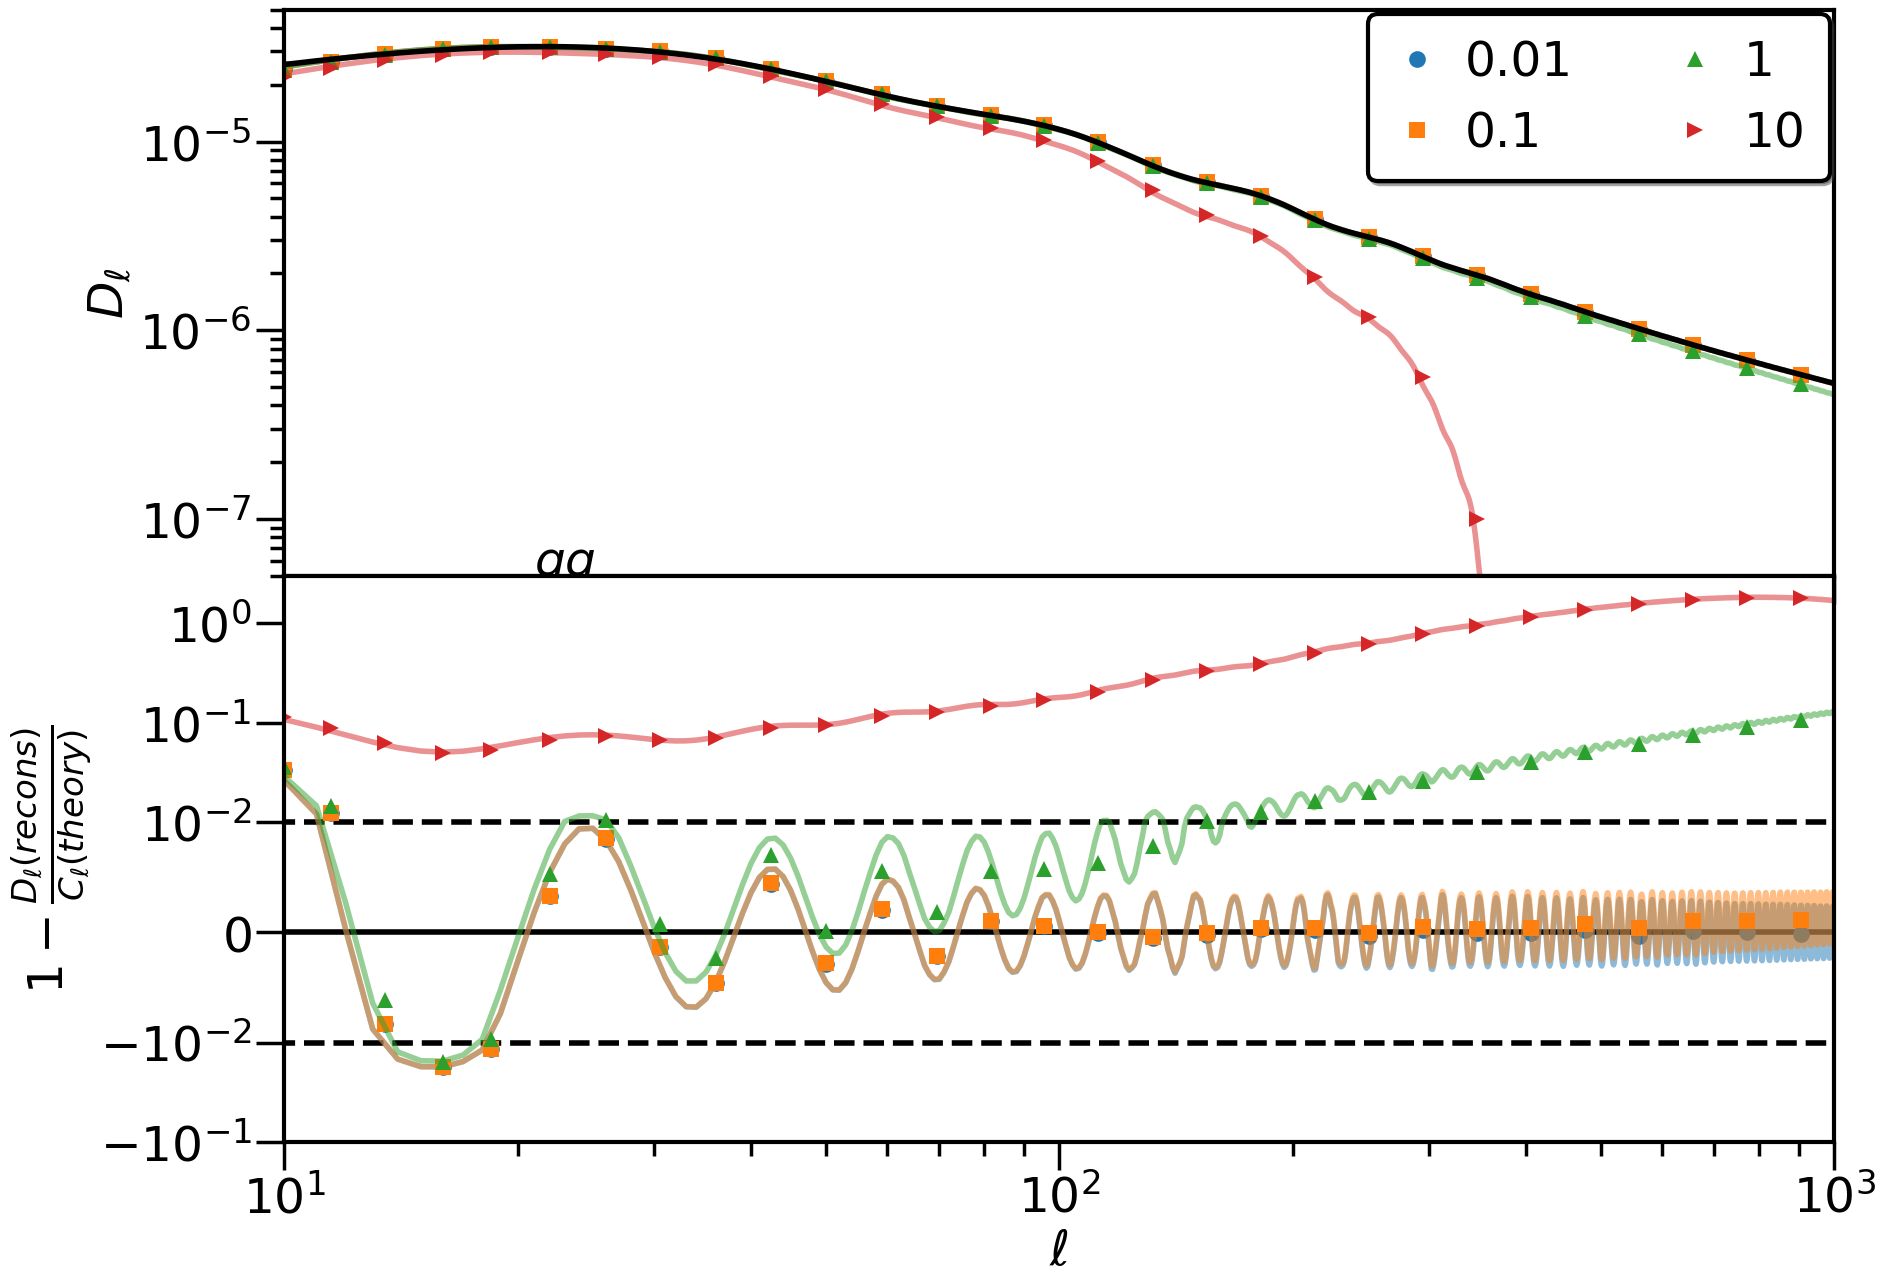

In [34]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,xi=xi0ub[corr][s][bi],s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
pS.plot(l_inv,cl0_0[corr][bi],alpha=1,zorder=10,c='k')
pS.plot(l_inv,cl_inv,c=colors[0],alpha=0.5)
pS.plot(lb,wd_bi2@xi0b[corr][s][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)


pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[0.1,1,10]
i=1
for thc in thcs:
    x=thb*60>thc
    xi_x=xi0b[corr][s][bi]*1.
    xi_x[~x]=0
    pS.plot(lb,(wd_bi2@xi_x),c=colors[i],marker=markers[i],label=str(thc),ls=None,lw=0)
    pR.plot(lb,1-(wd_bi2@xi_x)/cl0[corr][bi],c=colors[i],marker=markers[i],label=str(thc),ls=None,lw=0)
    x=th*60>thc
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th[x]*d2r,wig_theta=th[x]*d2r,xi=xi0ub[corr][s][bi][x],
                                              s1_s2=s,wig_d=WT.wig_d[s][x,:].T,wig_norm=WT.inv_wig_norm[x])
    pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[i],alpha=0.5)#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv,cl_inv,c=colors[i],alpha=0.5)#,label=r'$\theta_{min}=$'+str(thc))

    i+=1
pR.hlines(0,1,2000,color='k')
pR.hlines(.01,1,2000,color='k',ls='--')
pR.hlines(-0.01,1,2000,color='k',ls='--')
pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('symlog',linthreshy=0.01)
# ylim(0.9,1.121)
pR.set_ylim(-0.1,3)
pS.set_ylim(5.e-8,5.e-5)
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$1-\frac{D_\ell(recons)}{C_\ell (theory)}$')
pS.set_ylabel(r'$D_\ell$')
pS.text(x=21,y=5e-8,s=corr_labels[corr][s])
pS.legend(loc='upper right',ncol=2)
fname='WT_inv_th_min_comp_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

In [35]:
l0c=np.arange(lmax_cl)
window_l_test=np.arange(lmax_cl)
wl0c=window_l_test
wu=window_utils(l=l0c,window_l=window_l_test,use_window=True,s1_s2s={corr:s},
                corrs=corrs,wigner_step=100,wigner_files=wigner_files,bin_window=False)
wu.set_wig3j()
# wj2=client.compute(wu.wig_3j_2).result()
# wj2=wj2[0]['00']

Win gen: step size 100 3000 3000.0 10
wigner_files: {0: '/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/temp/dask_wig3j_l5000_w5000_0_reorder.zarr', 2: '/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/temp//dask_wig3j_l2200_w4400_2_reorder.zarr'}
wigner done dict_keys([])


In [36]:
xi_t=np.ones_like(xi0ub[corr][s][bi])
l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                          s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)


In [38]:
M_lm={}
Mw_lm={}

nl=len(l0c)
nlw=len(wl0c)
M=np.zeros((nl,nl))
Mw=np.zeros((nl,nlw))

# M_lm2={}
# M2=np.zeros((nl,nl))

for lm in wu.lms:
    wj2i=client.compute(wu.wig_3j_2[lm]).result()
    wj2i=wj2i['00']
    start_i=lm
    end_i=lm+wu.step
    l0ci=wl0c
    M_lm[lm]=wj2i@(wl_inv[l0ci]*(2*l0ci+1))
    M[start_i:end_i,:]+=M_lm[lm]

    wj2i=wj2i.transpose(0,2,1)
    l0ci=l0c
    Mw_lm[lm]=wj2i@(cl0_0[corr][bi][l0ci]*(2*l0ci+1))
    Mw[start_i:end_i,:]+=Mw_lm[lm]

    print(lm,'done')
M/=4.*np.pi
M*=(2*l0c+1)
Mw/=4.*np.pi
Mw*=(2*wl0c+1)

0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
1000 done
1100 done
1200 done
1300 done
1400 done
1500 done
1600 done
1700 done
1800 done
1900 done
2000 done
2100 done
2200 done
2300 done
2400 done
2500 done
2600 done
2700 done
2800 done
2900 done


<ipython-input-39-13bea37cfabe>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(l0c,l0c,M,norm=LogNorm(),cmap='Reds',rasterized=True)


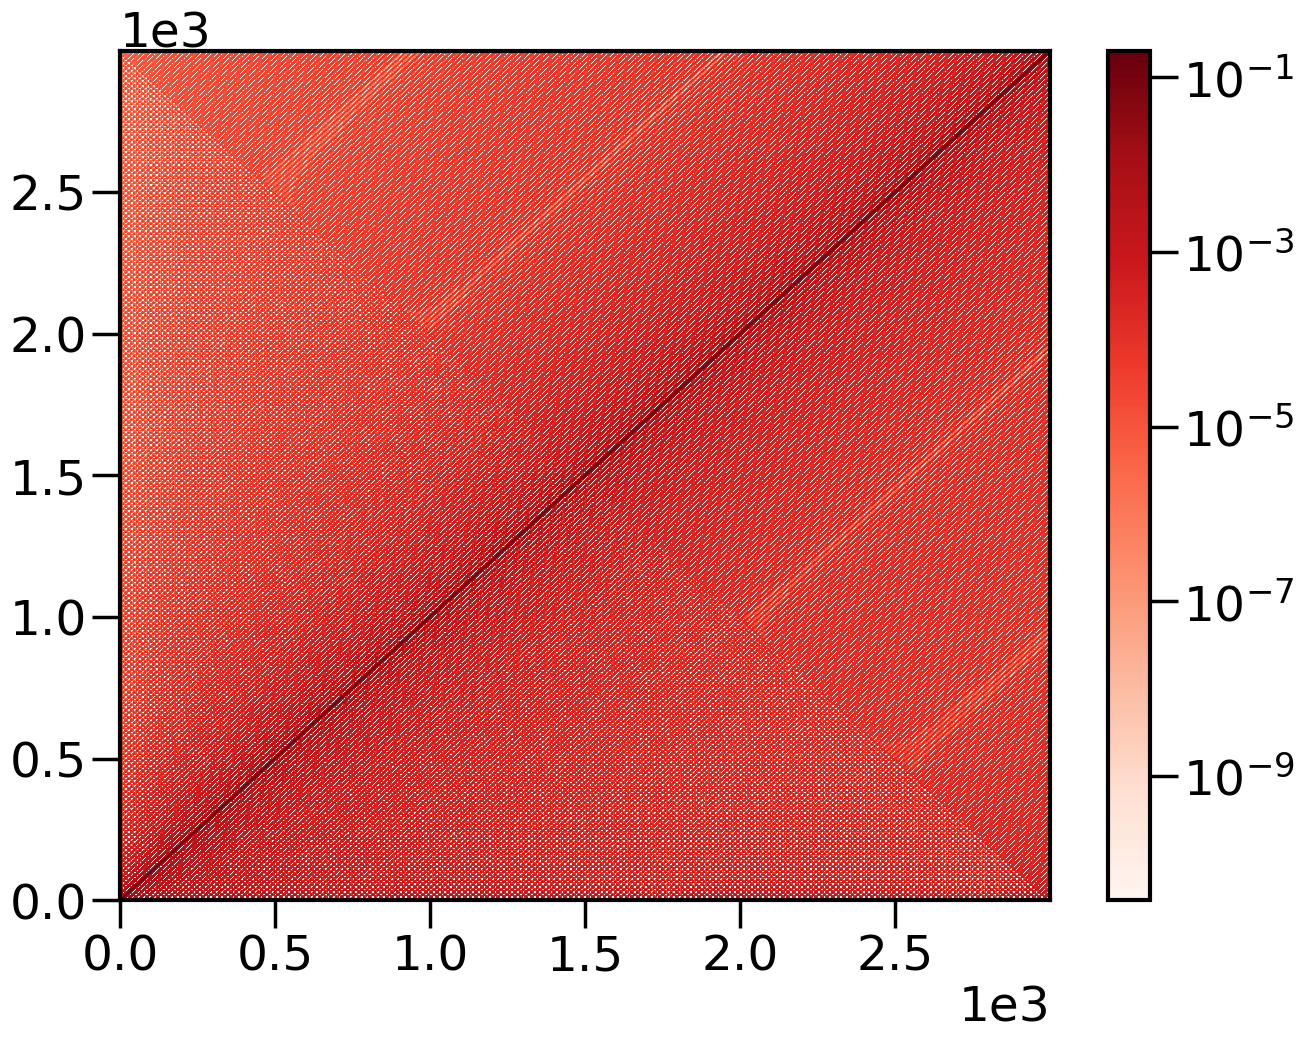

[]

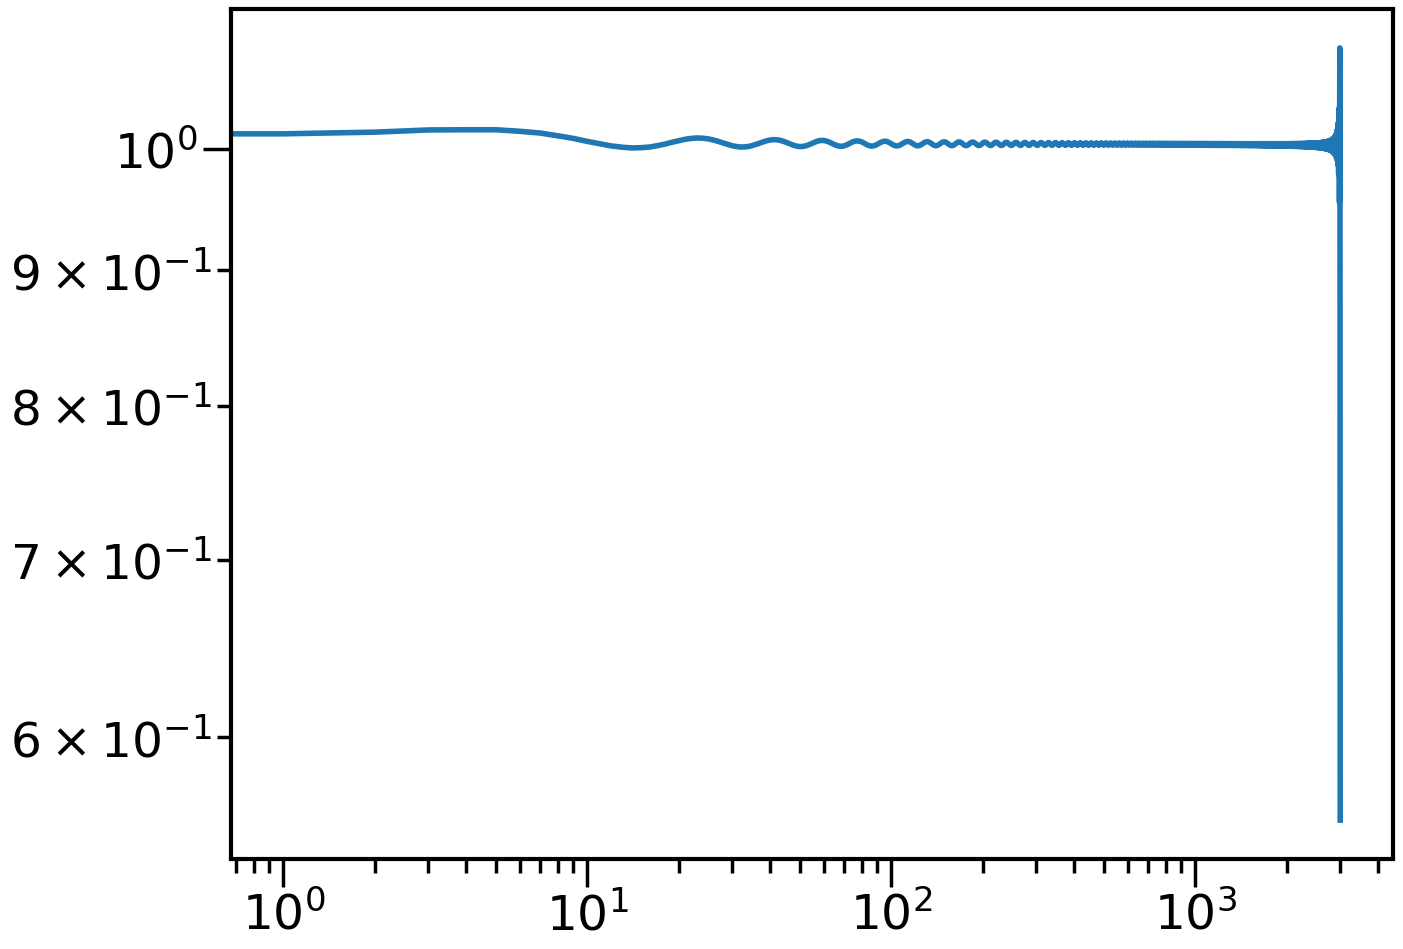

In [39]:
pcolor(l0c,l0c,M,norm=LogNorm(),cmap='Reds',rasterized=True)
colorbar()
# loglog()
# xlim(1,l0c.max())
# ylim(1,l0c.max())
show()
plot(M@np.ones_like(l0c))
loglog()

<ipython-input-40-1582150a6d3c>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(l0c,wl0c,Mw,norm=LogNorm(),cmap='Reds',rasterized=True)


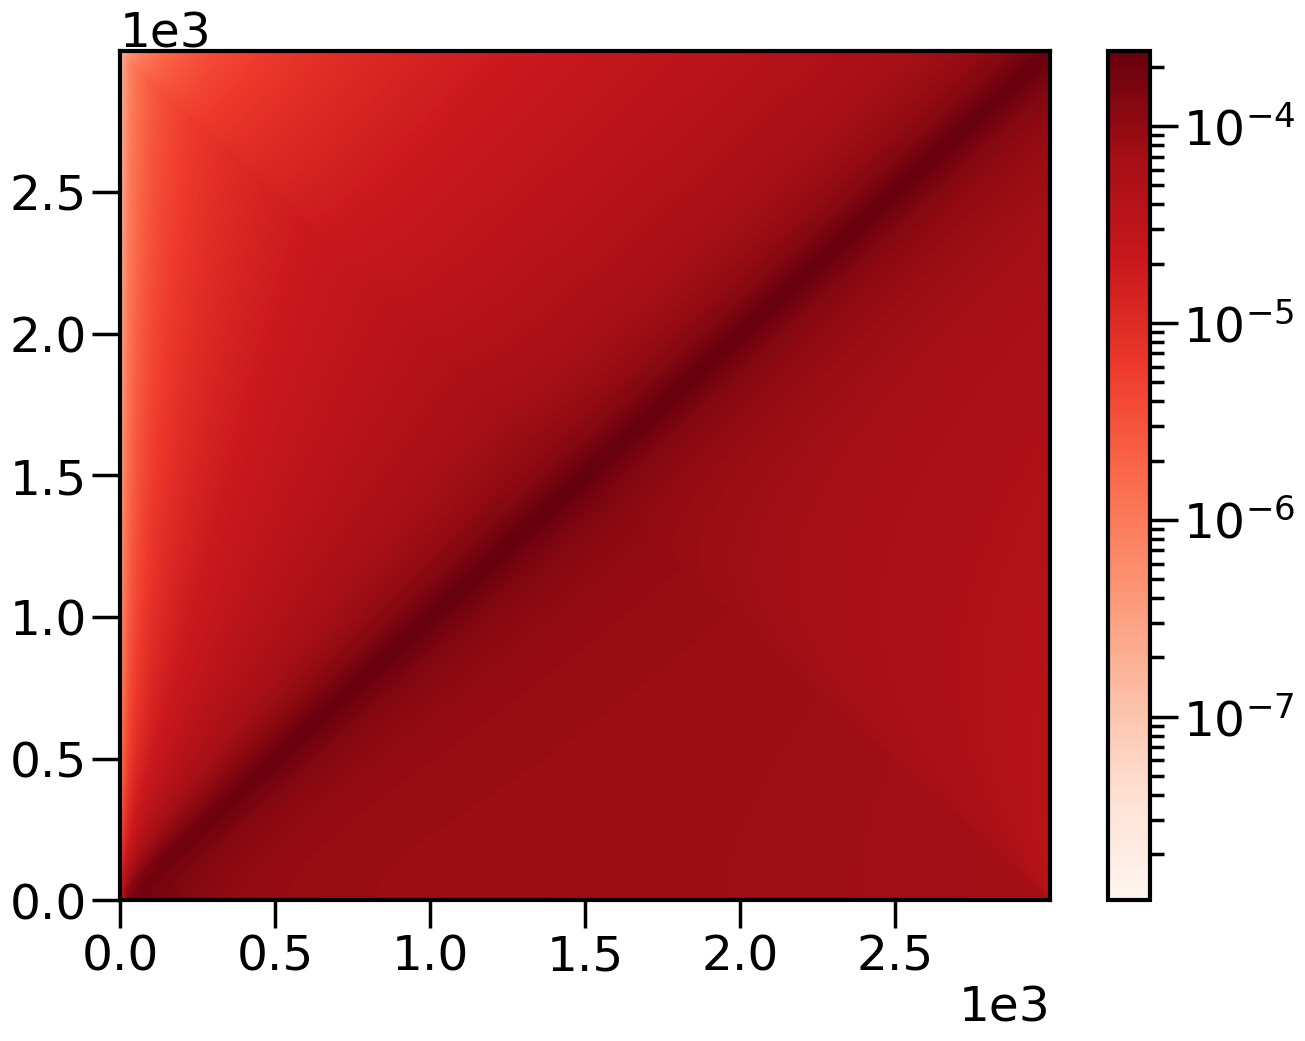

[]

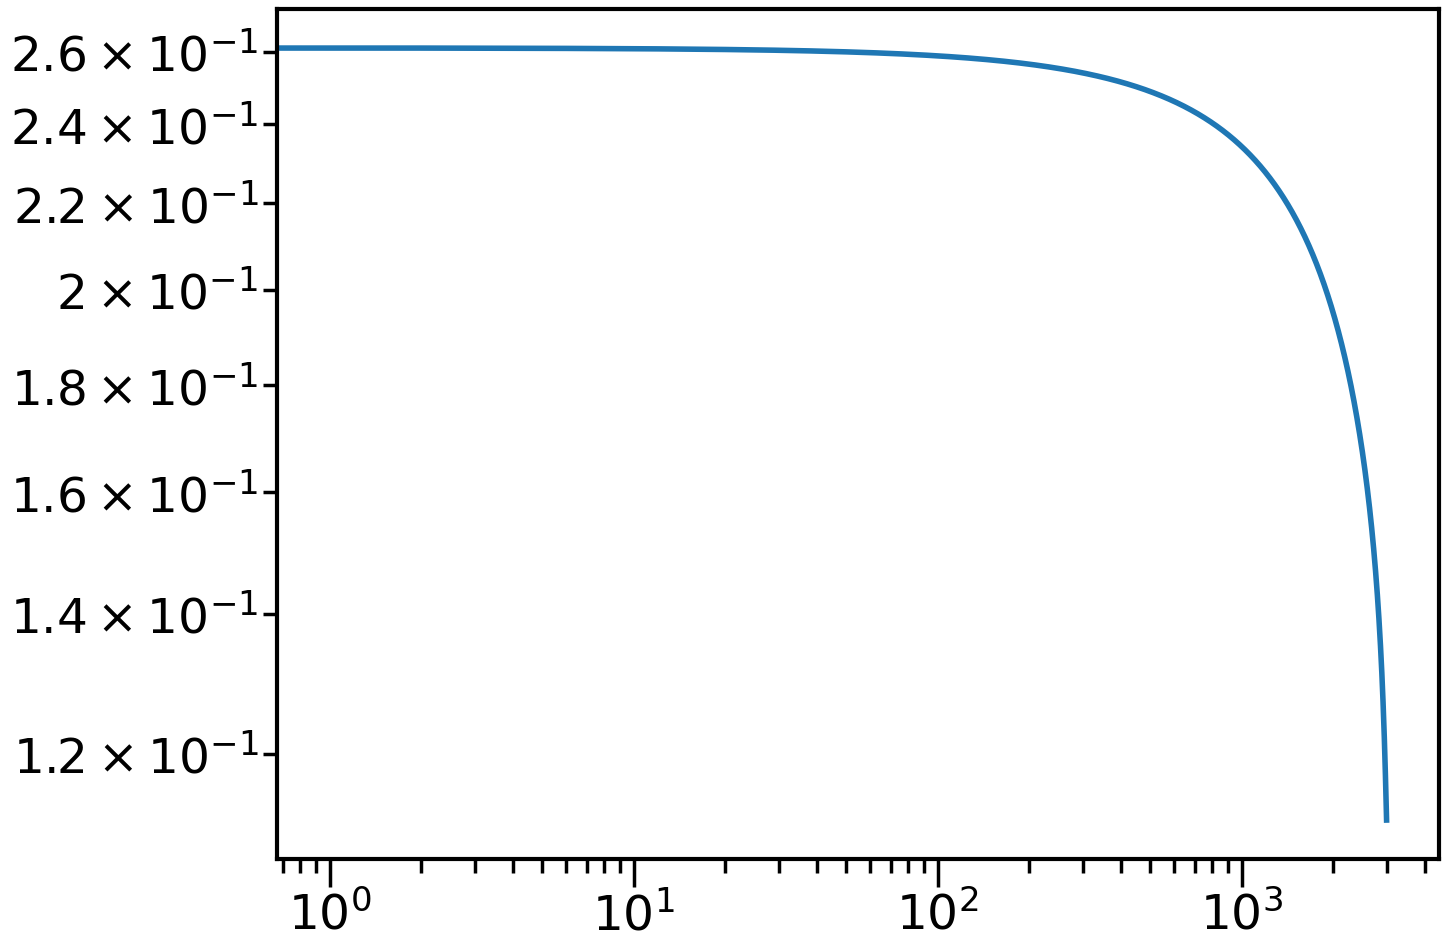

In [40]:
pcolor(l0c,wl0c,Mw,norm=LogNorm(),cmap='Reds',rasterized=True)
colorbar()
# loglog()
# xlim(1,l0c.max())
# ylim(1,l0c.max())
show()
plot(Mw@np.ones_like(wl0c))
loglog()

In [41]:
x=th*60>10
taper_f=np.cos((th[~x]-th[x].min())/(th[x].min()-theta_min)*np.pi/2.)**2

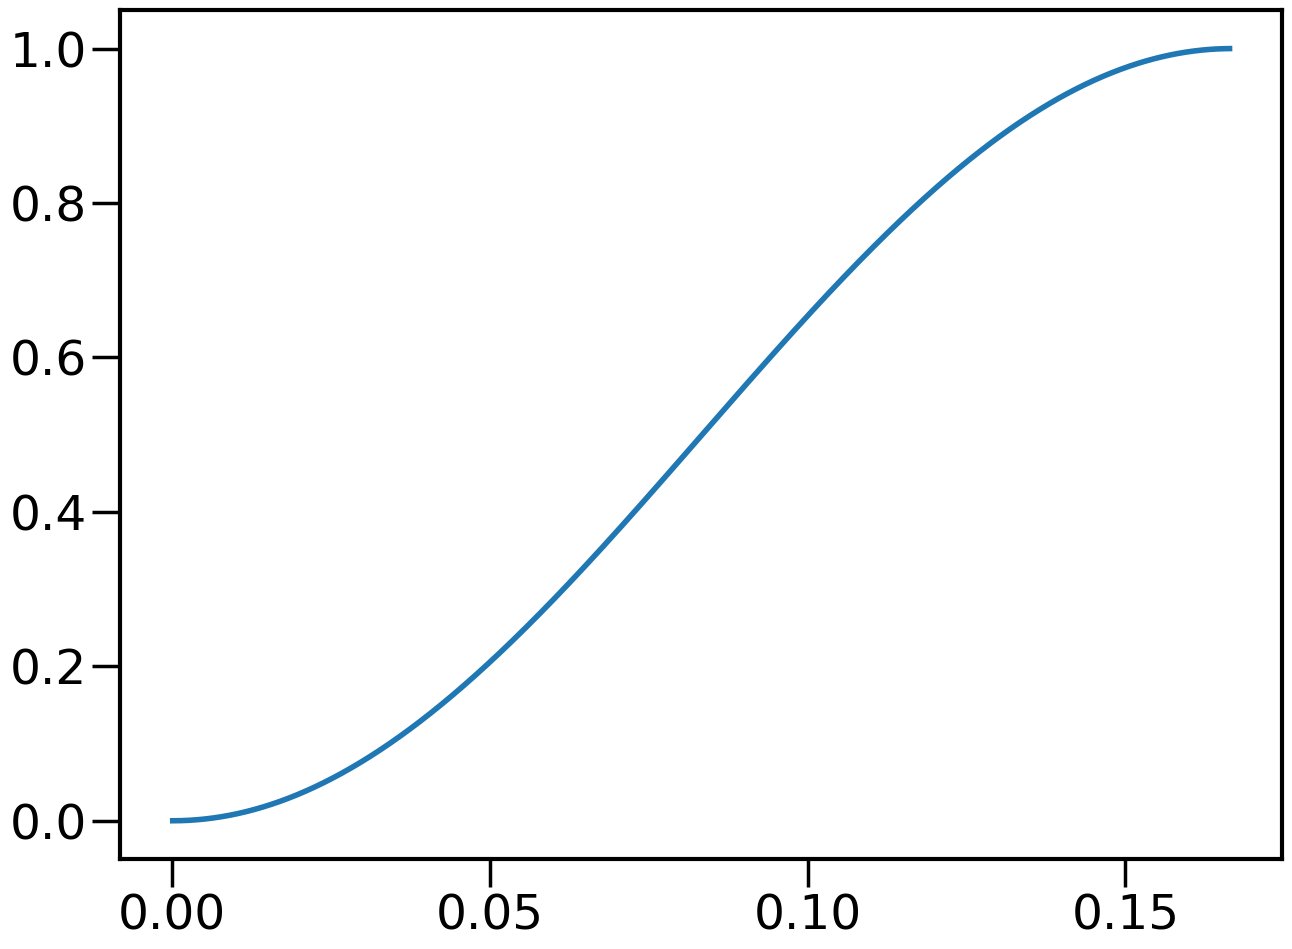

In [42]:
plot(th[~x],taper_f)

In [43]:
l_smooth_min=50
l_smooth_max=1000

saved to  ./figures/WT_inv_th_min_comp_convolve_unbinned_gg.pdf


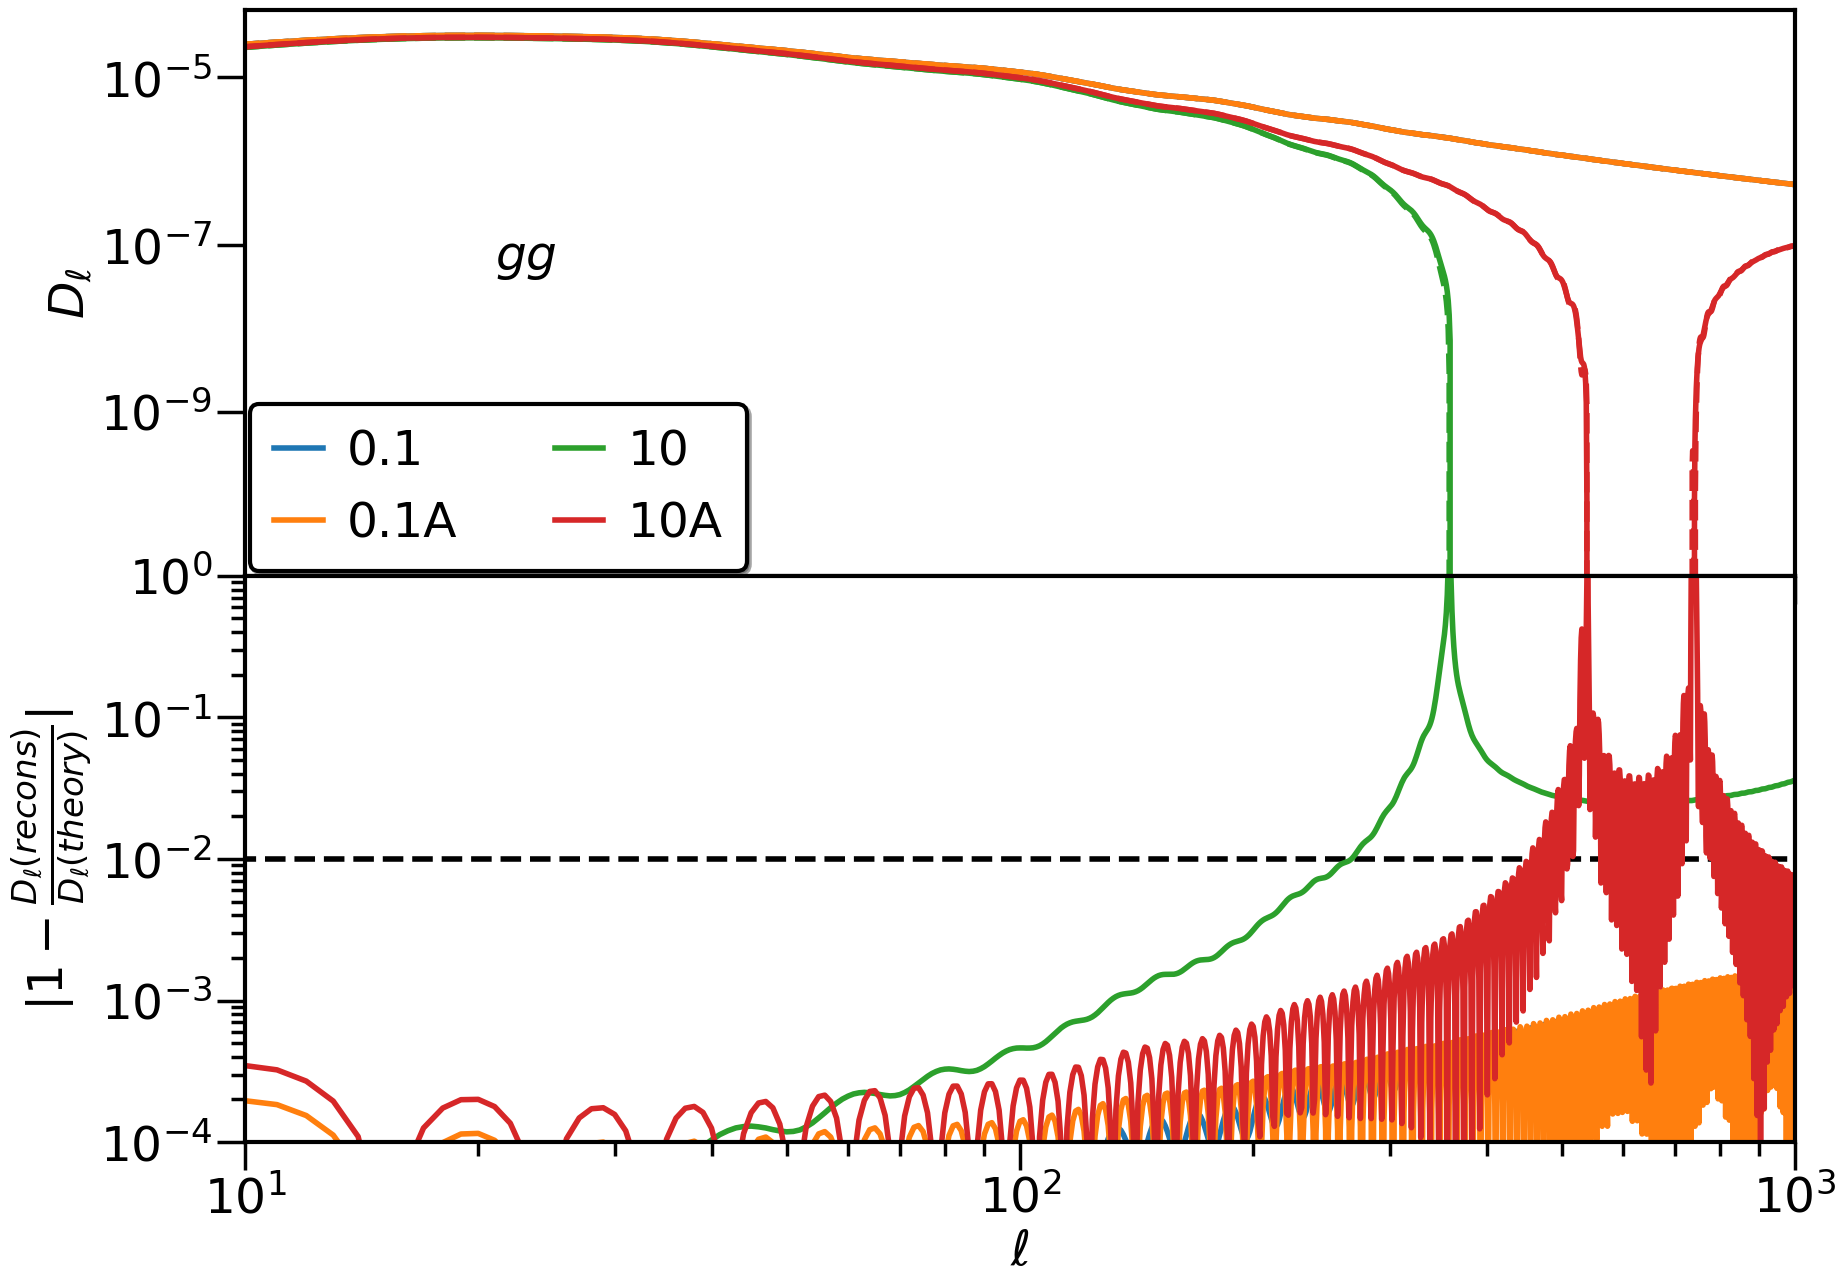

In [45]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
# l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,xi=xi0ub[corr][s][bi],s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
# pS.plot(l_inv,cl0_0[corr][bi],alpha=1,zorder=10,c='k')
# pS.plot(l_inv,cl_inv,c=colors[0],alpha=0.5)
# pS.plot(lb,wd_bi2@xi0b[corr][s][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)



# pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
# pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[.1,10]
th_max=600
i=0
for thc in thcs:
    x=th*60>thc
    xi_t=np.ones_like(xi0ub[corr][s][bi])
#     xi_t[~x]=np.cos((th[~x]-th[x].min())/(th[x].min()-theta_min)*np.pi/2.)
    xi_t[~x]=0
    
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi0ub[corr][s][bi]*xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    cl_inv0=cl0_0[corr][bi][l0c]
    
    
    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    
    cl_inv2=Mw@wl_inv[wl0c]#*(2*wl0c+1))
    pR.plot(l_inv[l0c],np.absolute(cl_inv2/cl_inv[l0c]-1),c=colors[i])#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv2,c=colors[i],label=str(thc),)#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv,c=colors[i],ls='--',)#,label=r'$\theta_{min}=$'+str(thc))
    
    i+=1

    x=l_inv<l_smooth_min/thc
    x2=l_inv<l_smooth_max
    x=x*x2
    wl_inv[~x]*=np.cos((l_inv[~x]-l_inv[x].max())/(l_smooth_max-l_inv[x].max())*np.pi/2.)
    wl_inv[~x2]*=0
    
    tht,xi_t2=WT.projected_correlation(l_cl=l_inv,cl=wl_inv,s1_s2=s,wig_d=WT.wig_d[s],wig_norm=WT.wig_norm)
#     xi_t/=xi_t.max()
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi0ub[corr][s][bi]*xi_t2,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    cl_inv2=Mw@wl_inv[wl0c]
    
    pR.plot(l_inv[l0c],np.absolute(cl_inv2/cl_inv[l0c]-1),c=colors[i])#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv2,c=colors[i],label=str(thc)+'A',)#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv,c=colors[i],ls='--',)

    i+=1
    
pR.hlines(0,1,2000,color='k')
pR.hlines(.01,1,2000,color='k',ls='--')
pR.hlines(-0.01,1,2000,color='k',ls='--')
pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('log')
# pR.set_yscale('symlog',linthreshy=0.01)
pR.set_ylim(1.e-4,1)
# pS.set_ylim(5.e-9,5.e-6)
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$|1-\frac{D_\ell(recons)}{D_\ell (theory)}|$')
pS.set_ylabel(r'$D_\ell$')
pS.text(x=21,y=5e-8,s=corr_labels[corr][s])
pS.legend(loc='lower left',ncol=2)
fname='WT_inv_th_min_comp_convolve_unbinned_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
# fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

[]

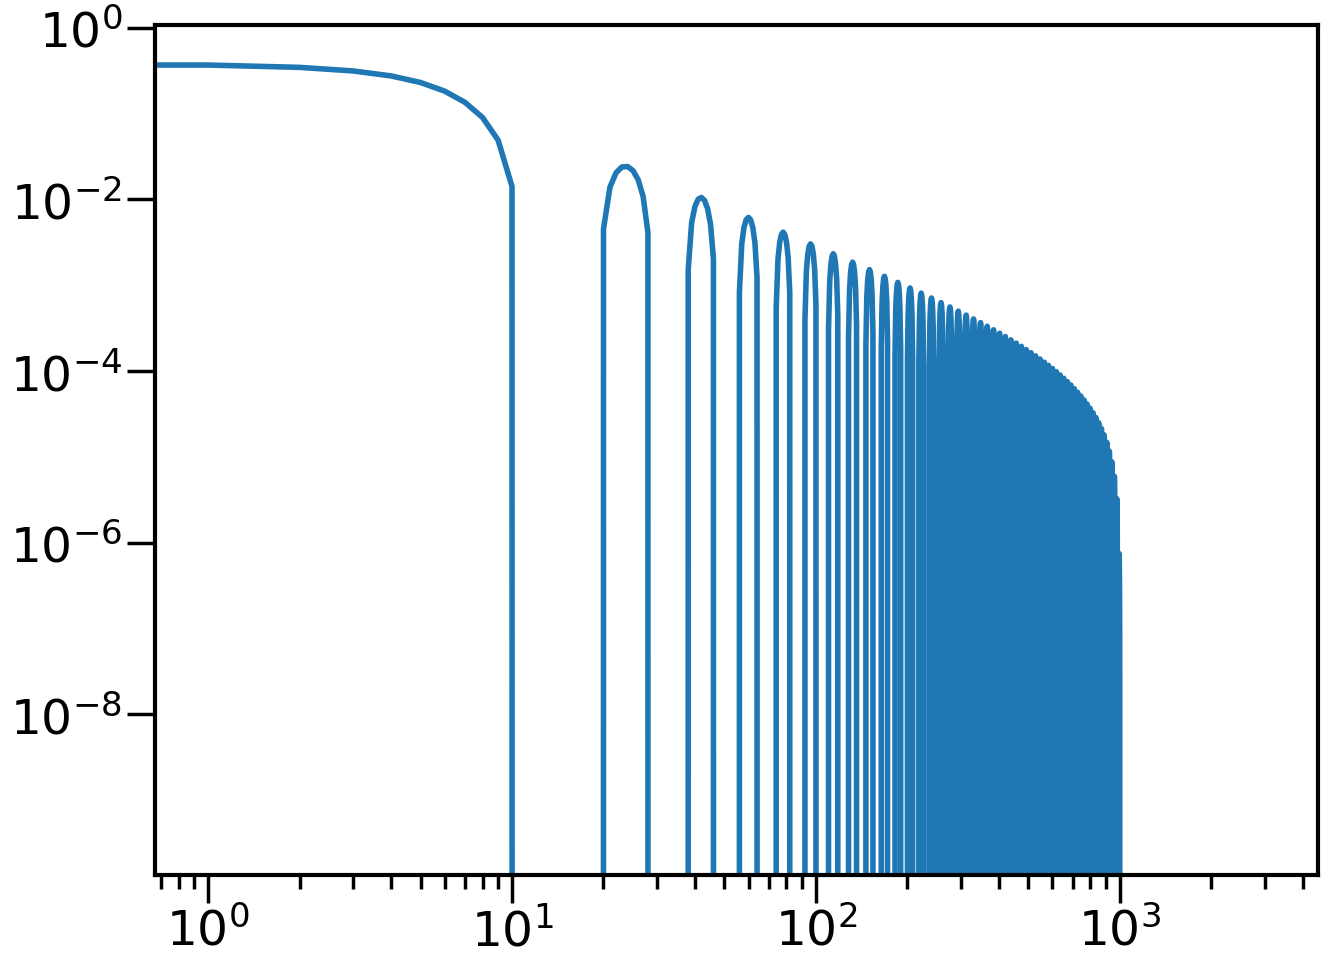

In [46]:
plot(l,wl_inv)
loglog()

saved to  ./figures/correlation_apodized_scale_cut.pdf


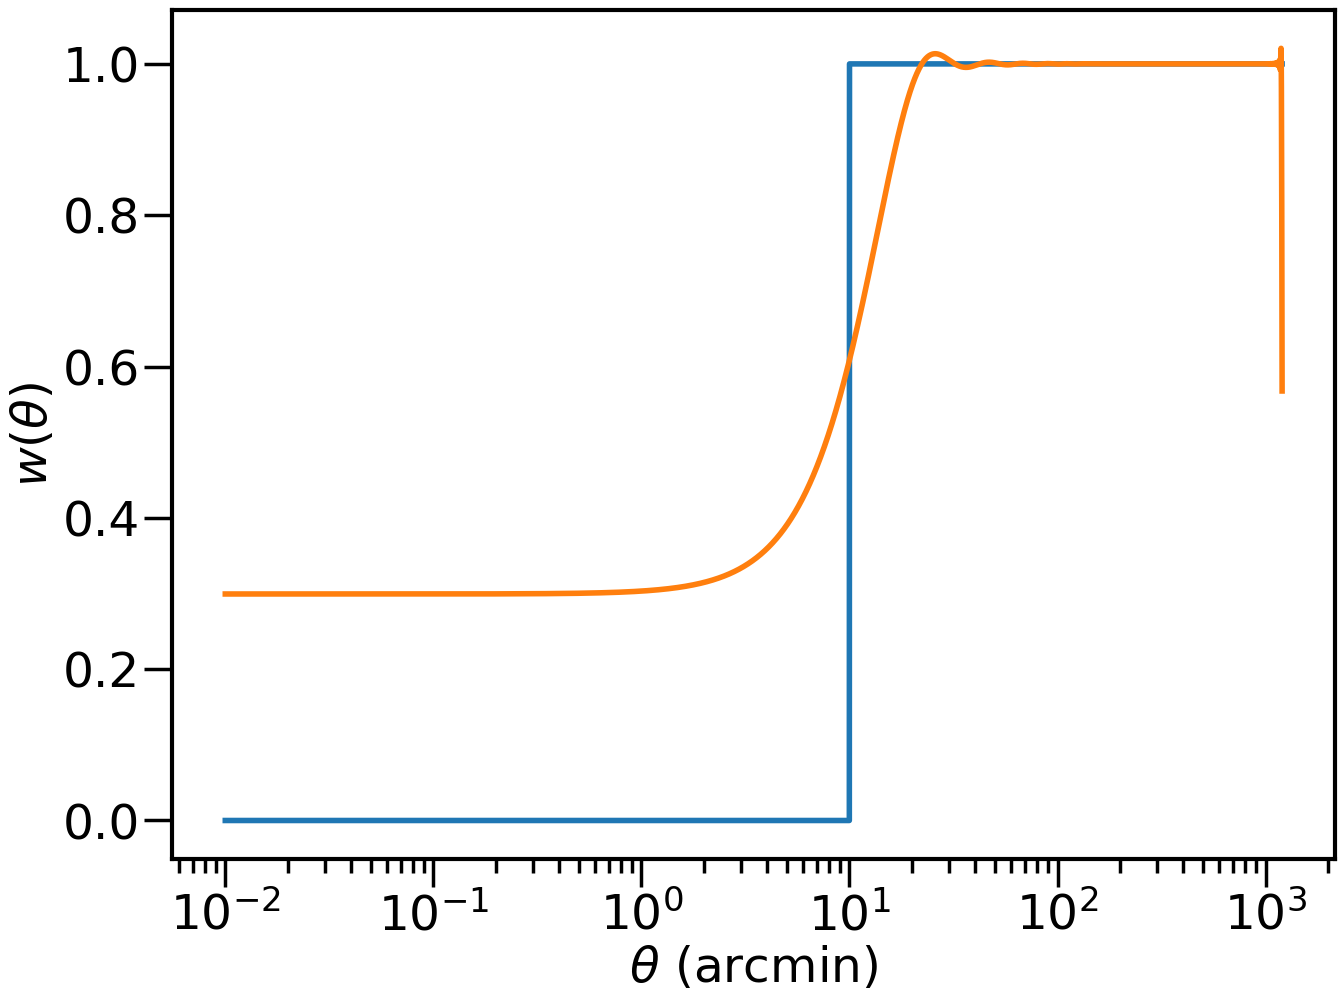

In [47]:
plot(th*60,xi_t,label='top hat')
plot(th*60,xi_t2,label='Apodized')
xscale('log')
xlabel(r'$\theta$ (arcmin)')
ylabel(r'$w(\theta)$')
fname='correlation_apodized_scale_cut'
fname=fig_home+fname
fname+='.pdf'
savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    


In [48]:
Mwb=SL_xi0_ub.binning.bin_1d(xi=Mw.T,bin_utils=cl_bu)
Mwb=Mwb.T

In [49]:
Mb=SL_xi0_ub.binning.bin_2d_coupling(M=M,bin_utils=cl_bu,wt0=cl0_0[corr][bi],wt_b=1./cl0[corr][bi])

bin_2d_coupling:  (3000, 43) (43,) (3000,)
bin_2d_coupling again:  (3000, 43) (43,) (3000,)


<ipython-input-50-d5ea3281fc11>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(lb,lb,Mb*-1,cmap='Blues',rasterized=True,norm=LogNorm(),vmax=1,vmin=1.e-6)
<ipython-input-50-d5ea3281fc11>:1: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  pcolor(lb,lb,Mb*-1,cmap='Blues',rasterized=True,norm=LogNorm(),vmax=1,vmin=1.e-6)
<ipython-input-50-d5ea3281fc11>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='a

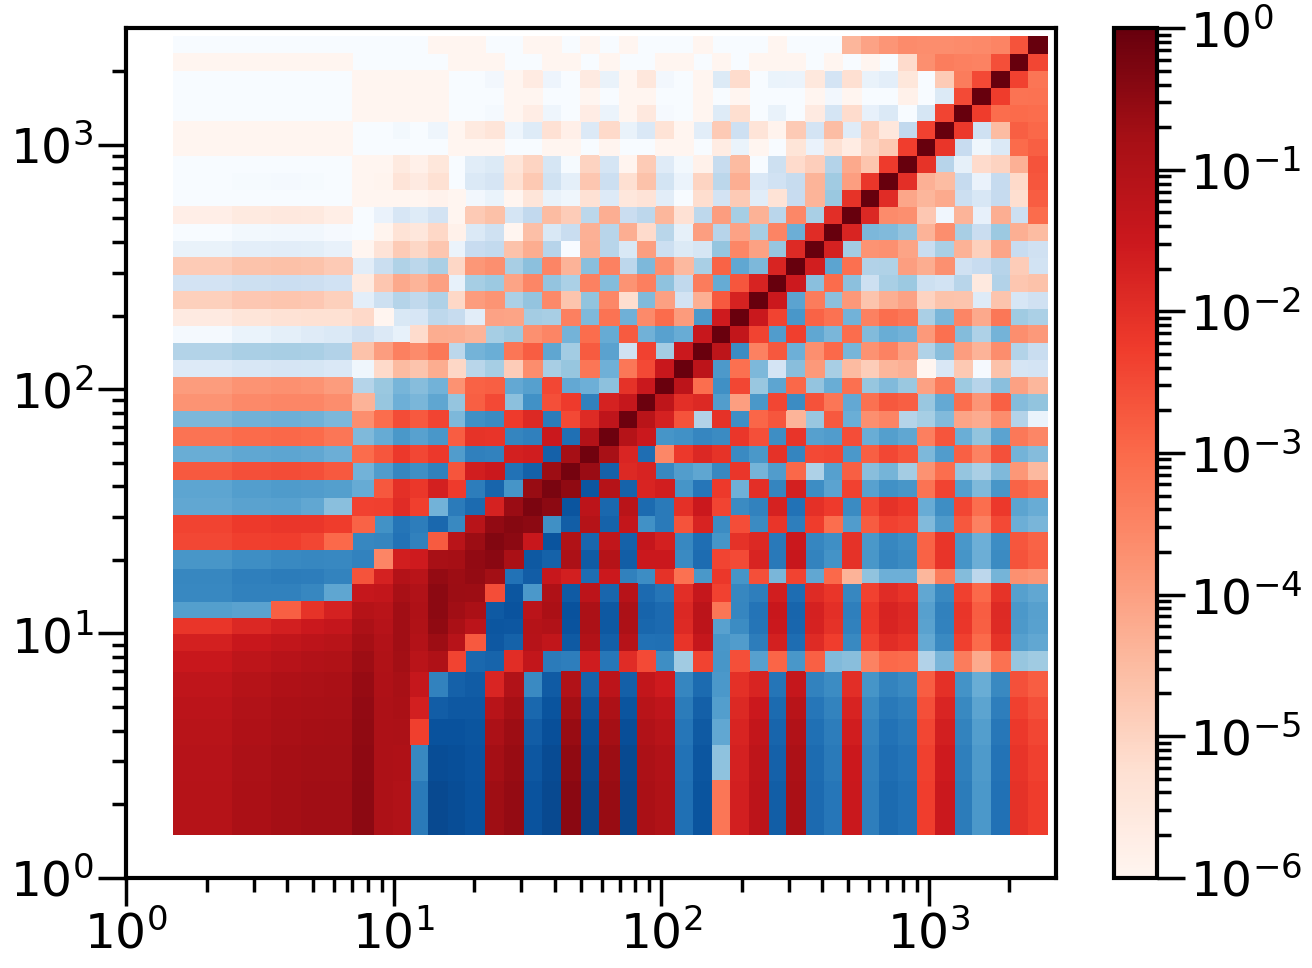

In [50]:
pcolor(lb,lb,Mb*-1,cmap='Blues',rasterized=True,norm=LogNorm(),vmax=1,vmin=1.e-6)
pcolor(lb,lb,Mb,cmap='Reds',rasterized=True,norm=LogNorm(),vmax=1,vmin=1.e-6)
colorbar()
loglog()
xlim(1,l0c.max())
ylim(1,l0c.max())
show()

saved to  ./figures/WT_inv_th_min_comp_convolve_binned_gg.pdf


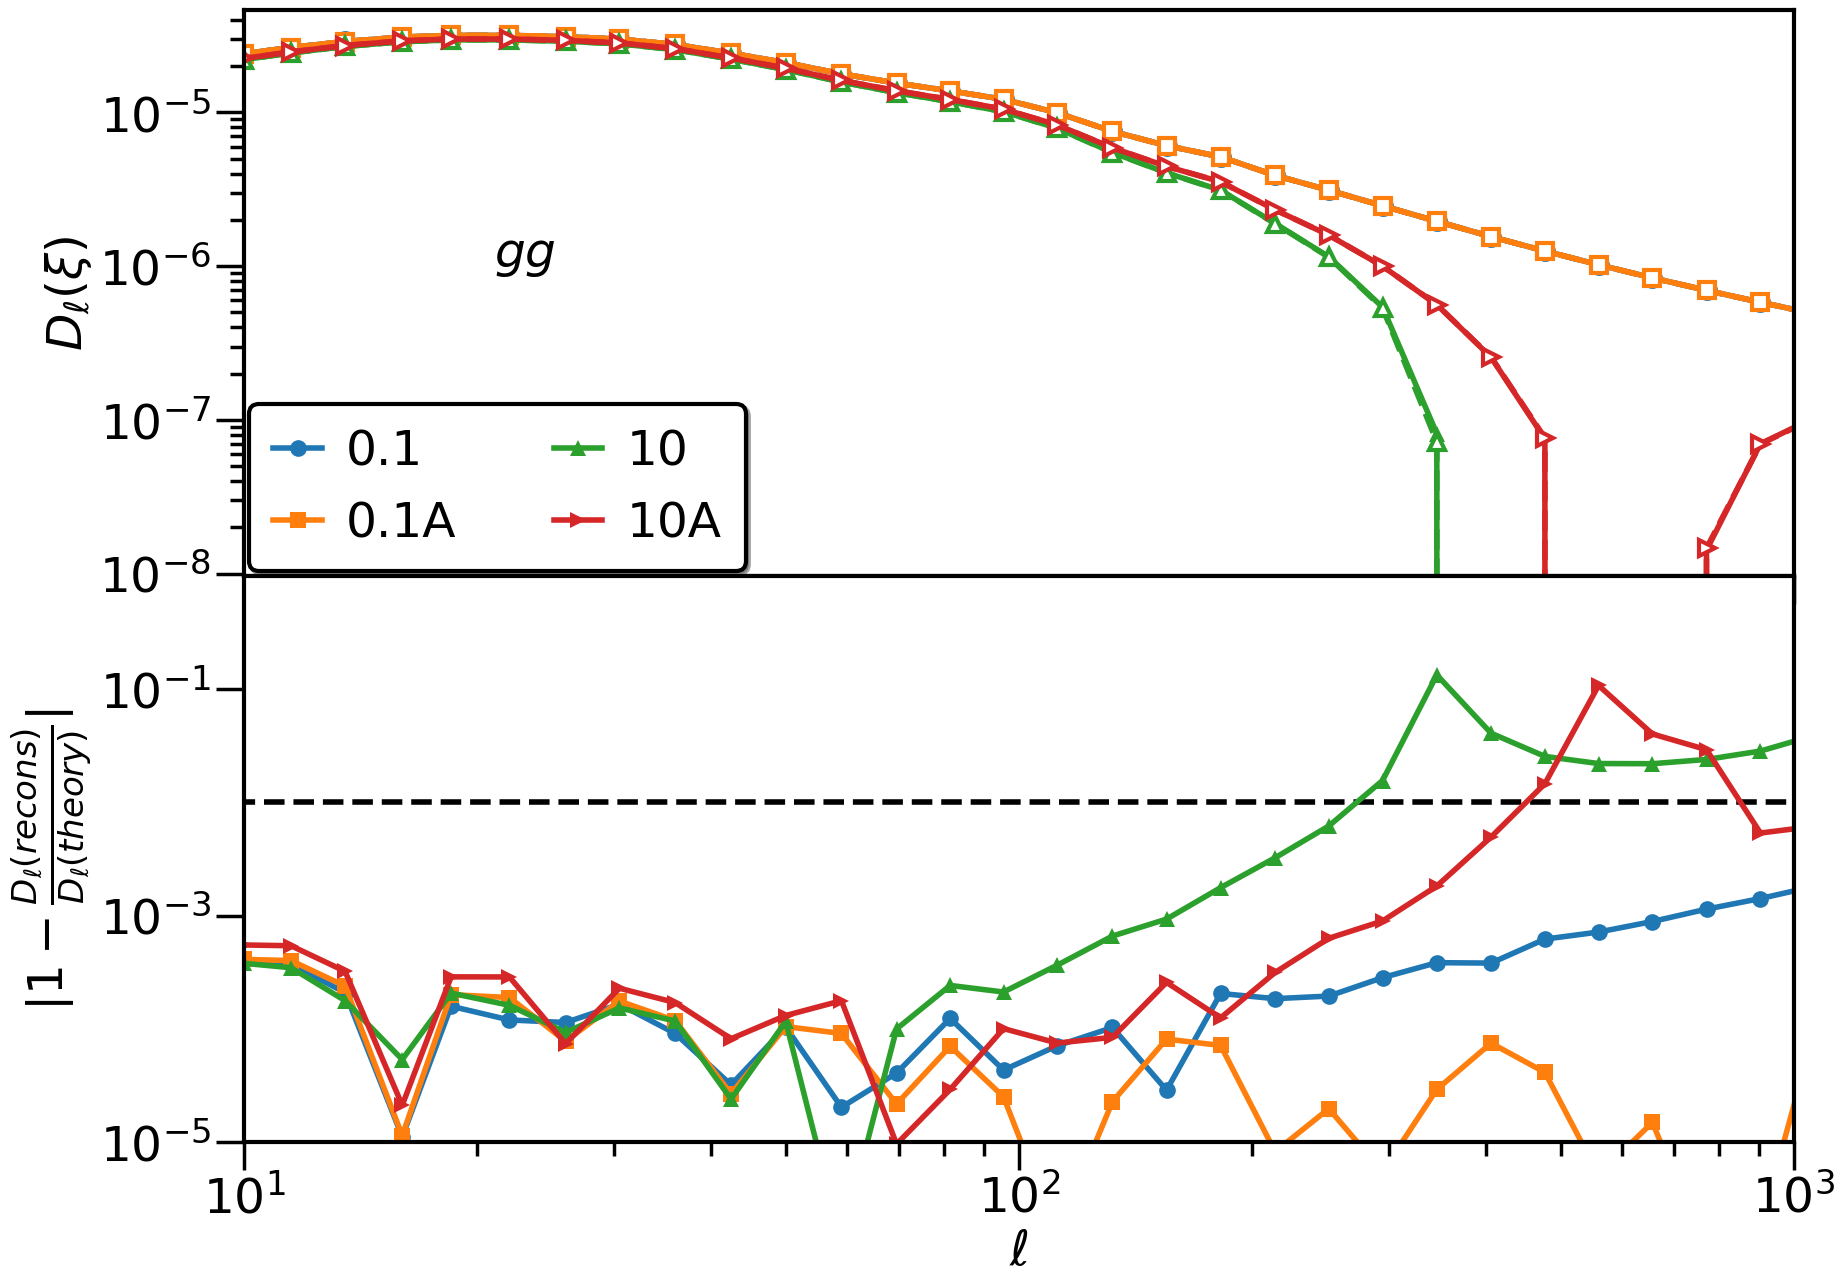

In [61]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
# l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,xi=xi0ub[corr][s][bi],s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
# pS.plot(l_inv,cl0_0[corr][bi],alpha=1,zorder=10,c='k')
# pS.plot(l_inv,cl_inv,c=colors[0],alpha=0.5)
# pS.plot(lb,wd_bi2@xi0b[corr][s][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)



# pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
# pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[.1,10]
th_max=600
i=0
for thc in thcs:
    x=th*60>thc
    xi_t=np.ones_like(xi0ub[corr][s][bi])
#     xi_t[~x]=np.cos((th[~x]-th[x].min())/(th[x].min()-theta_min)*np.pi/2.)
    xi_t[~x]=0

    xi_tb=SL_xi0_ub.binning.bin_1d(xi=xi_t,bin_utils=xi_bu[s])
#     x=thb*60>thc
#     xi_tb=np.ones_like(xi0[corr][s][bi])
#     xi_tb[~x]=0
    cl_inv_b=wd_bi2@(xi0[corr][s][bi]*xi_tb)
    
    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    
#     cl_inv2=Mwb@wl_inv[wl0c]#*(2*wl0c+1))
    cl_inv2=Mw@wl_inv[wl0c]#*(2*wl0c+1))
    cl_inv2=SL_xi0_ub.binning.bin_1d(xi=cl_inv2,bin_utils=cl_bu)
    pR.plot(lb,np.absolute(cl_inv2/cl_inv_b-1),c=colors[i],marker=markers[i])#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(lb,cl_inv2,c=colors[i],label=str(thc),marker=markers[i])
    pS.plot(lb,cl_inv_b,c=colors[i],ls='--',marker=markers[i],mfc='white',mew=3)
    
    i+=1

    
    x=l_inv<l_smooth_min/thc
    x2=l_inv<l_smooth_max
    x=x*x2
    wl_inv[~x]*=np.cos((l_inv[~x]-l_inv[x].max())/(l_smooth_max-l_inv[x].max())*np.pi/2.)
    wl_inv[~x2]*=0

    tht,xi_t2=WT.projected_correlation(l_cl=l_inv,cl=wl_inv,s1_s2=s,wig_d=WT.wig_d[s],wig_norm=WT.wig_norm)
    
    xi_tb2=SL_xi0_ub.binning.bin_1d(xi=xi_t2,bin_utils=xi_bu[s])
    cl_inv_b=wd_bi2@(xi0[corr][s][bi]*xi_tb2)
    
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi0ub[corr][s][bi]*xi_t2,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    
    cl_inv2=Mwb@wl_inv[wl0c]#*(2*wl0c+1))
    pS.plot(lb,cl_inv2,c=colors[i],label=str(thc)+'A',marker=markers[i])
    pS.plot(lb,cl_inv_b,c=colors[i],ls='--',marker=markers[i],mfc='white',mew=3)

    pR.plot(lb,np.absolute(cl_inv2/cl_inv_b-1),c=colors[i],ls='-',marker=markers[i])#,label=r'$\theta_{min}=$'+str(thc))
    i+=1
    
pR.hlines(0,1,2000,color='k')
pR.hlines(.01,1,2000,color='k',ls='--')
pR.hlines(-0.01,1,2000,color='k',ls='--')
pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('log')
# pR.set_yscale('symlog',linthreshy=0.01)
pR.set_ylim(1.e-5,1)
# pS.set_ylim(5.e-9,5.e-6)
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$|1-\frac{D_\ell(recons)}{D_\ell (theory)}|$')
pS.set_ylabel(r'$D_\ell (\xi)$')
pS.text(x=21,y=1.e-6,s=corr_labels[corr][s])
pS.legend(loc='lower left',ncol=2)
fname='WT_inv_th_min_comp_convolve_binned_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

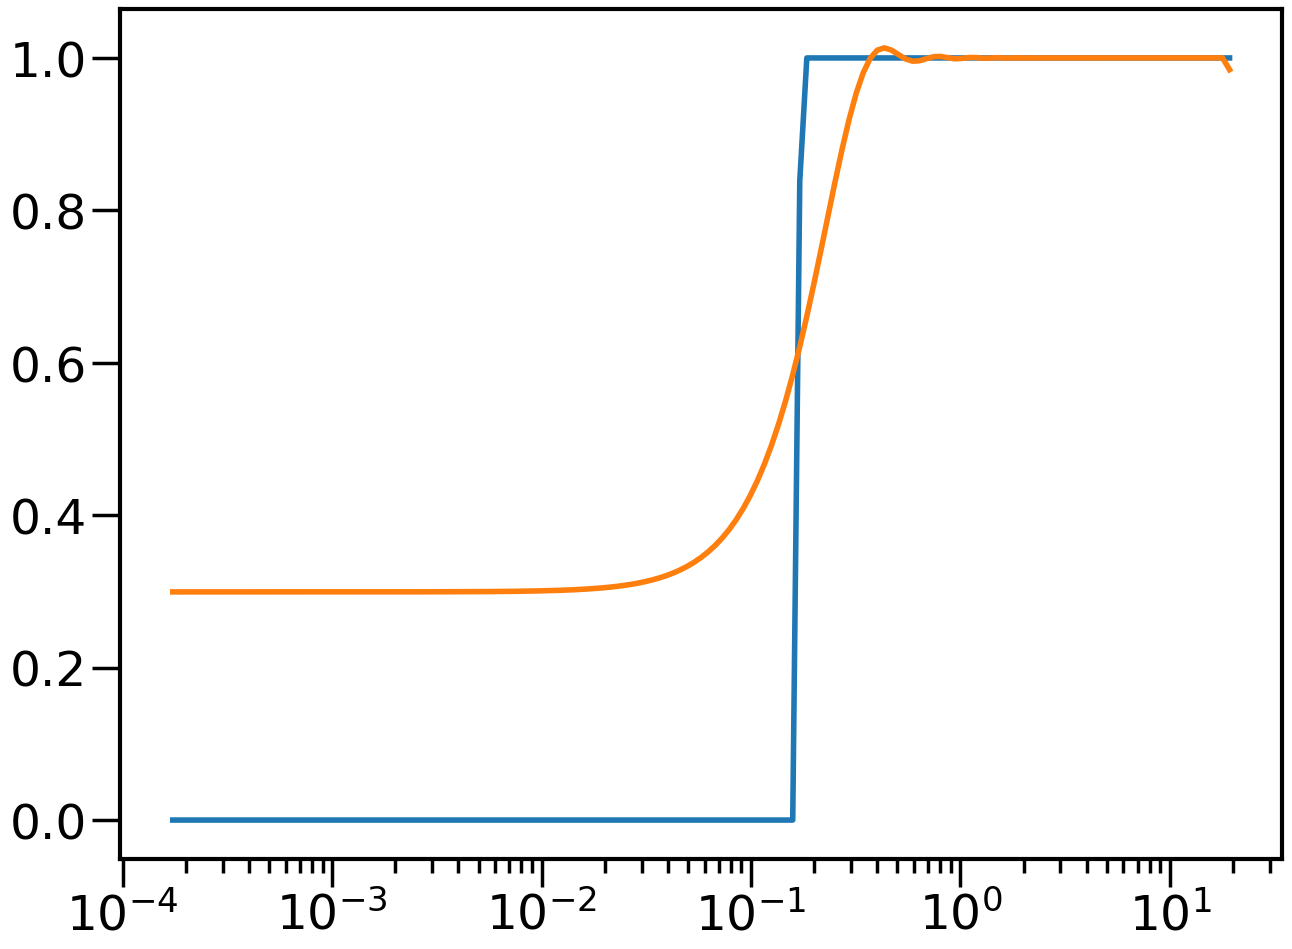

In [52]:
plot(thb,xi_tb)
plot(thb,xi_tb2)
xscale('log')

saved to  ./figures/WT_inv_th_min_comp_convolve_binned_imaster_gg.pdf


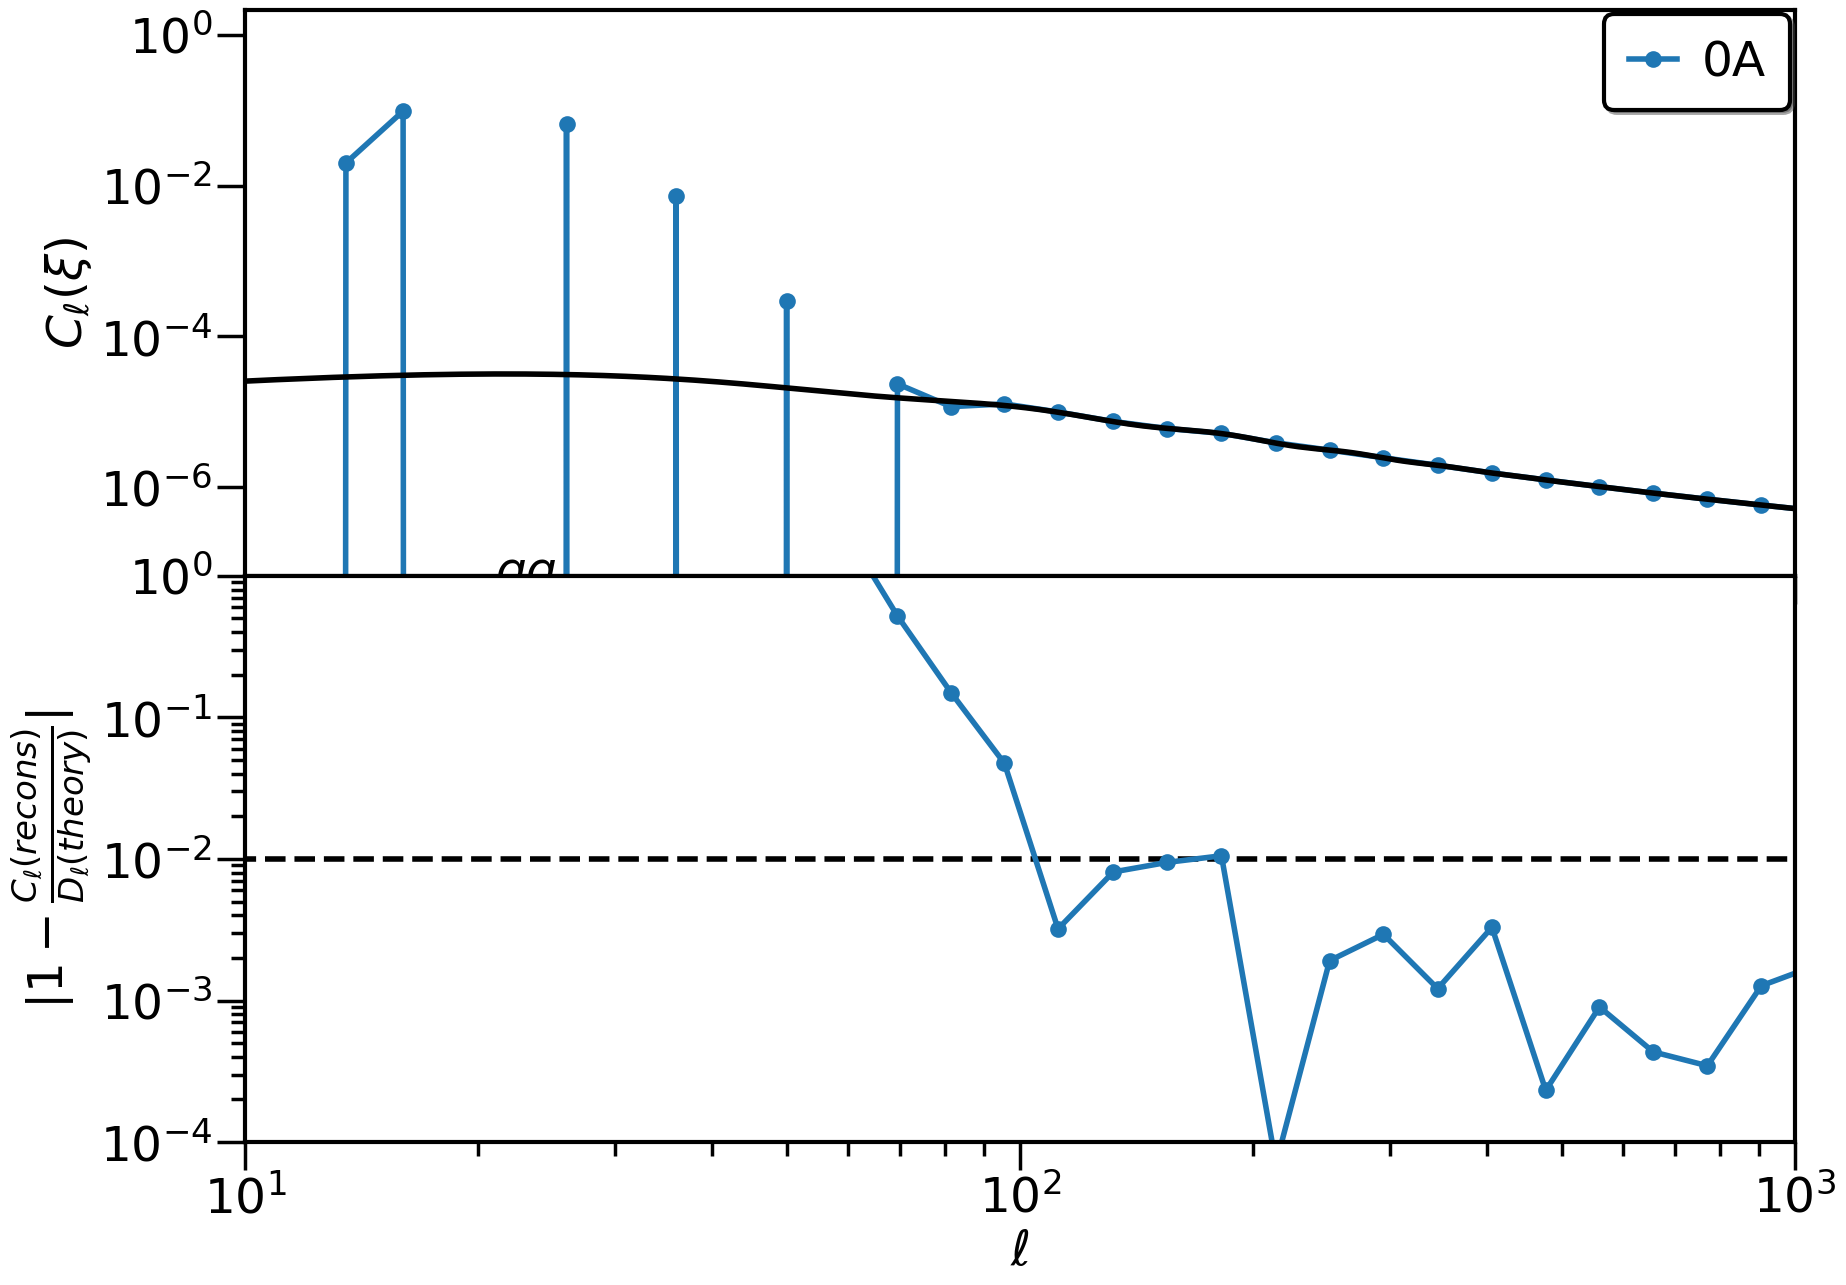

In [58]:
#reconstructed C_ell.
#see iMaster_SN for better version of this plot.
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
pS.plot(l0,cl0_0[corr][bi],alpha=1,zorder=10,c='k')



# pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
# pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[0]
th_max=600
i=0
for thc in thcs:
    x=th*60>thc
    xi_t=np.ones_like(xi0ub[corr][s][bi])
    xi_t[~x]=0

    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
        
    x=l_inv<l_smooth_min
    x2=l_inv<l_smooth_max
    x=x*x2
    wl_inv[~x]*=np.cos((l_inv[~x]-l_inv[x].max())/(l_smooth_max-l_inv[x].max())*np.pi/2.)
    wl_inv[~x2]*=0

    tht,xi_t2=WT.projected_correlation(l_cl=l_inv,cl=wl_inv,s1_s2=s,wig_d=WT.wig_d[s],wig_norm=WT.wig_norm)
    
    xi_tb2=SL_xi0_ub.binning.bin_1d(xi=xi_t2,bin_utils=xi_bu[s])
    cl_inv_b=wd_bi2@(xi0[corr][s][bi]*xi_tb2)
    
    Mi=np.linalg.inv(Mb)
    cl2=(Mi@wd_bi2)@(xi0[corr][s][bi]*xi_tb2)
#     cl2=Mi@cl_inv_b
#     cl2=M@cl0_0[corr][bi]
#     cl2=Mb@cl0[corr][bi]
    pS.plot(lb,cl2,c=colors[i],label=str(thc)+'A',marker=markers[i])
#     pS.plot(l0c,cl2,c=colors[i],label=str(thc)+'A',marker=markers[i])

    pR.plot(lb,np.absolute(cl2/cl0[corr][bi]-1),c=colors[i],ls='-',marker=markers[i])#,label=r'$\theta_{min}=$'+str(thc))
    i+=1
    
pR.hlines(0,1,2000,color='k')
pR.hlines(.01,1,2000,color='k',ls='--')
pR.hlines(-0.01,1,2000,color='k',ls='--')
pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('log')
# pR.set_yscale('symlog',linthreshy=0.01)
pR.set_ylim(1.e-4,1)
# pS.set_ylim(5.e-9,5.e-6)
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$|1-\frac{C_\ell(recons)}{D_\ell (theory)}|$')
pS.set_ylabel(r'$C_\ell (\xi)$')
pS.text(x=21,y=5e-8,s=corr_labels[corr][s])
pS.legend(loc='upper right',ncol=2)
fname='WT_inv_th_min_comp_convolve_binned_imaster_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
# fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()